In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
exc = 0.4
inh = 0.322

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t_pen = 0.96

In [5]:
file_ = '1_I.pickle'
folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = '1'

/high_osc


In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
c_var = [1]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # osc to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [7]:
bestControl_ = None

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]

file found


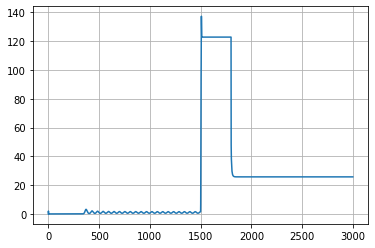

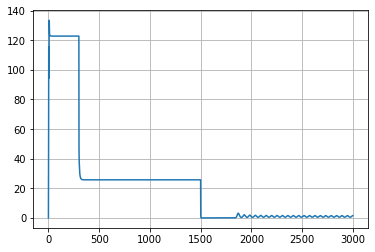

1.5457440477540358
25.73160170281955


In [8]:
# get initial parameters and target states
data.set_parameters(aln)

aln.params.ext_exc_current = exc * 5.
aln.params.ext_inh_current = inh * 5.

aln.params.duration = 3000.

control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = max_I[0])

aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

target_rates = np.zeros((2))
target_rates[0] = aln.rates_exc[0,-1] 
target_rates[1] = aln.rates_inh[0,-1]

control0 = functions.step_control(aln, maxI_ = max_I[1])
aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars
target = [target_rates[0], target_rates[1]]

print(initVars[0])
print(target[0])

In [9]:
# get uncontrolled cost
    
aln.params.duration = dur

target_ = aln.getZeroTarget()
target_[:,0,:] = target[0]
target_[:,1,:] = target[1]

cost.setParams(wp, 0.0, 0.0)

setinit(initVars, aln)
control0 = aln.getZeroControl()

cgv = None
max_it = 0

bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

cost_uncontrolled = cost_init_[0]

set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  313.59573137650784
RUN  0 , total integrated cost =  313.59573137650784
Gradient descend method:  None
RUN  0 , total integrated cost =  313.59573137650784
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  17.41933384829731
RUN  2 , total integrated cost =  7.26308384829731
RUN  3 , total integrated cost =  6.823630723297379
RUN  4 , total integrated cost =  6.805320177806189
RUN  5 , total integrated cost =  6.804370491692708
RUN  6 , total integrated cost =  4.949956302654845
RUN  7 , total integrated cost =  4.933171632161485
RUN  8 , total integrated cost =  4.9322196637924245
RUN  9 , total integrated cost =  4.932173451605437
RUN  10 , total integrated cost =  4.930906072571601
RUN  10 , total integrated cost =  4.930906072571601
Improved over  10  iterations in  22.36248832801357  seconds by  96.8171138165362  percent.


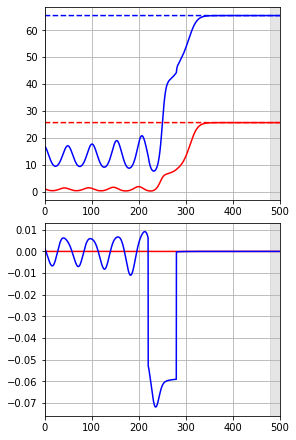

uncontrolled cost :  313.59573137650784
cost splitting :  1.4024391940796237e-07 [0.         0.49309061]


In [10]:
cgv = None
j = 0

aln.params.duration = dur
setinit(initVars, aln)

target_ = aln.getZeroTarget()
target_[:,0,:] = target[0]
target_[:,1,:] = target[1]

control0 = aln.getZeroControl()
cost.setParams(wp, 0., 10.)
max_it = int(10)

control0[0,1,2200:2800] = -2.

bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

if True:
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,6) )
    ax[1].plot(plot_time_array, bestControl_[0,0,n_pre-1:-n_post+1], color = 'red')
    ax[0].plot(plot_time_array, bestState_[0,0,n_pre-1:-n_post+1], color= 'red')
    ax[1].plot(plot_time_array, bestControl_[0,1,n_pre-1:-n_post+1], color = 'blue')
    ax[0].plot(plot_time_array, bestState_[0,1,n_pre-1:-n_post+1], color= 'blue')
    ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
    ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

    for k in range(2):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

print('uncontrolled cost : ', cost_uncontrolled)
print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])    

set cost params:  0.05 0.0 235.46508380024235
interpolate adjoint :  True True True
initial cost =  116.10562100081906
RUN  0 , total integrated cost =  116.10562100081906
Gradient descend method:  None
RUN  1 , total integrated cost =  112.72159965446005
RUN  2 , total integrated cost =  112.6968323266493
RUN  3 , total integrated cost =  112.6968323266493
Control only changes marginally.
RUN  3 , total integrated cost =  112.6968323266493
Improved over  3  iterations in  0.979824762995122  seconds by  2.9359376788017073  percent.
cost splitting :  0.0003598557993104587 [0.        0.4786137]
set cost params:  0.05 0.0 305.30571630192867
interpolate adjoint :  True True True
initial cost =  146.1235156674332
RUN  0 , total integrated cost =  146.1235156674332
Gradient descend method:  None
RUN  1 , total integrated cost =  146.1235156674332
Control only changes marginally.
RUN  1 , total integrated cost =  146.1235156674332
Improved over  1  iterations in  0.4470731309847906  seconds b

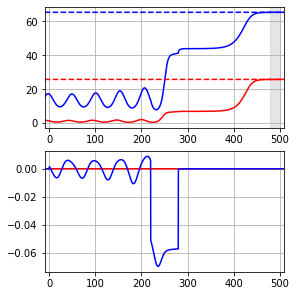

In [11]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-6
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0]
        target_[:,1,:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.05 0.0 174.40790616205908
interpolate adjoint :  True True True
initial cost =  83.47403079282492
RUN  0 , total integrated cost =  83.47403079282492
Gradient descend method:  None
RUN  1 , total integrated cost =  83.47357639419889
RUN  2 , total integrated cost =  83.47344369868132
RUN  3 , total integrated cost =  83.47306314462182
RUN  4 , total integrated cost =  83.47293162298871
RUN  5 , total integrated cost =  83.47260469455021
RUN  6 , total integrated cost =  83.47247258856457
RUN  7 , total integrated cost =  83.47212318175167
RUN  8 , total integrated cost =  83.47198492652598
RUN  9 , total integrated cost =  83.47155220084144
RUN  10 , total integrated cost =  83.4711676032273
RUN  11 , total integrated cost =  83.23904042471129
RUN  12 , total integrated cost =  83.23761744424681
RUN  13 , total integrated cost =  83.05781999674338
RUN  14 , total integrated cost =  77.13998856079567
RUN  15 , total integrated cost =  77.13495975075986
RUN  16 , tota

RUN  8 , total integrated cost =  93.38058440135775
RUN  9 , total integrated cost =  93.3805787316312
RUN  10 , total integrated cost =  93.38057377798323
RUN  11 , total integrated cost =  93.38056795880976
RUN  12 , total integrated cost =  93.38056310547596
RUN  13 , total integrated cost =  93.38055718479579
RUN  14 , total integrated cost =  93.38055238194552
RUN  15 , total integrated cost =  93.38054717776197
RUN  16 , total integrated cost =  93.38054207080314
RUN  17 , total integrated cost =  93.38053640974832
RUN  18 , total integrated cost =  93.38053145611406
RUN  19 , total integrated cost =  93.38052564029246
RUN  20 , total integrated cost =  93.38052078765091
RUN  30 , total integrated cost =  93.38046776946405
RUN  30 , total integrated cost =  93.38046776946405
Improved over  30  iterations in  7.027722104015993  seconds by  0.0002869497765232154  percent.
cost splitting :  0.0034780203755358755 [1.04396551e-08 3.12691822e-01]
set cost params:  0.05 0.0 895.27567536

RUN  18 , total integrated cost =  80.31355654243943
RUN  19 , total integrated cost =  80.31353765451739
RUN  20 , total integrated cost =  80.31329654234868
RUN  30 , total integrated cost =  80.31310118522381
RUN  30 , total integrated cost =  80.31310118522381
Improved over  30  iterations in  7.064702752017183  seconds by  0.0009292962902094359  percent.
cost splitting :  0.0029975304553896227 [1.04396551e-08 3.12151907e-01]
set cost params:  0.05 0.0 924.5181709534824
interpolate adjoint :  True True True
initial cost =  288.5902699843526
RUN  0 , total integrated cost =  288.5902699843526
Gradient descend method:  None
RUN  1 , total integrated cost =  288.58991801744236
RUN  2 , total integrated cost =  288.52052251044734
RUN  3 , total integrated cost =  288.51254884145897
RUN  4 , total integrated cost =  288.51254884145897
Control only changes marginally.
RUN  4 , total integrated cost =  288.51254884145897
Improved over  4  iterations in  1.406430947012268  seconds by  0.02

RUN  17 , total integrated cost =  239.53700871939324
RUN  18 , total integrated cost =  239.5369999266662
RUN  19 , total integrated cost =  239.53698967898617
RUN  20 , total integrated cost =  239.53698088836674
RUN  30 , total integrated cost =  239.53688572561367
RUN  30 , total integrated cost =  239.53688572561367
Improved over  30  iterations in  8.524612948996946  seconds by  0.12714424792892487  percent.
cost splitting :  0.0074545791278882905 [1.04396551e-08 3.11320342e-01]
set cost params:  0.05 0.0 753.4010780340036
interpolate adjoint :  True True True
initial cost =  234.54946190132145
RUN  0 , total integrated cost =  234.54946190132145
Gradient descend method:  None
RUN  1 , total integrated cost =  234.54946190132145
Control only changes marginally.
RUN  1 , total integrated cost =  234.54946190132145
Improved over  1  iterations in  0.44347887599724345  seconds by  0.0  percent.
cost splitting :  0.0074545791278882905 [1.04396551e-08 3.11320342e-01]


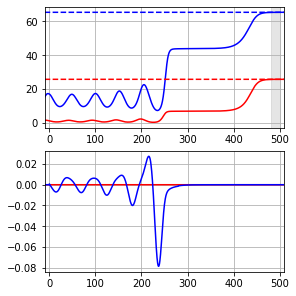

In [12]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-8
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0]
        target_[:,1,:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.05 0.0 158.62269920258134
interpolate adjoint :  True True True
initial cost =  49.382847356034524
RUN  0 , total integrated cost =  49.382847356034524
Gradient descend method:  None
RUN  1 , total integrated cost =  49.38271717607149
RUN  2 , total integrated cost =  49.38270805533291
RUN  3 , total integrated cost =  49.38270025504213
RUN  4 , total integrated cost =  49.38267805160333
RUN  5 , total integrated cost =  49.382661278573025
RUN  6 , total integrated cost =  49.37402258823007
RUN  7 , total integrated cost =  49.33504295097258
RUN  8 , total integrated cost =  49.33478875715449
RUN  9 , total integrated cost =  49.334786961522425
RUN  10 , total integrated cost =  49.33478613958329
RUN  11 , total integrated cost =  49.33478527089004
RUN  12 , total integrated cost =  49.3347846285037
RUN  13 , total integrated cost =  49.334783917013795
RUN  14 , total integrated cost =  49.33478335706192
RUN  15 , total integrated cost =  49.33478271226186
RUN  16 ,

RUN  7 , total integrated cost =  241.28298413686525
RUN  8 , total integrated cost =  241.2829681125014
RUN  9 , total integrated cost =  241.08073667121607
RUN  10 , total integrated cost =  241.07856860542208
RUN  11 , total integrated cost =  241.07854538263751
RUN  12 , total integrated cost =  241.07853777910537
RUN  13 , total integrated cost =  241.07852893495803
RUN  14 , total integrated cost =  241.0785232031959
RUN  15 , total integrated cost =  241.07851659805004
RUN  16 , total integrated cost =  241.07851007314318
RUN  17 , total integrated cost =  241.07850291139962
RUN  18 , total integrated cost =  241.07849678077574
RUN  19 , total integrated cost =  241.07848990260493
RUN  20 , total integrated cost =  241.07848356157447
RUN  30 , total integrated cost =  241.07841679361073
RUN  30 , total integrated cost =  241.07841679361073
Improved over  30  iterations in  9.187820669991197  seconds by  0.08601898733236624  percent.
cost splitting :  0.00813214497317572 [1.04921

RUN  17 , total integrated cost =  130.48372710263413
RUN  18 , total integrated cost =  130.48372426877665
RUN  19 , total integrated cost =  130.48372129671895
RUN  20 , total integrated cost =  130.4837183518629
RUN  30 , total integrated cost =  130.4836884245641
RUN  30 , total integrated cost =  130.4836884245641
Improved over  30  iterations in  9.609153286990477  seconds by  8.853698317068392e-05  percent.
cost splitting :  0.005137551890605531 [1.04921542e-10 3.09939199e-01]
set cost params:  0.05 0.0 354.55258185716804
interpolate adjoint :  True True True
initial cost =  109.89000001855962
RUN  0 , total integrated cost =  109.89000001855962
Gradient descend method:  None
RUN  1 , total integrated cost =  109.88999795450323
RUN  2 , total integrated cost =  109.88999571896032
RUN  3 , total integrated cost =  109.88999380295012
RUN  4 , total integrated cost =  109.88999159328203
RUN  5 , total integrated cost =  109.88998965689704
RUN  6 , total integrated cost =  109.88998

RUN  1 , total integrated cost =  230.0739345544121
RUN  2 , total integrated cost =  230.07393069585234
RUN  3 , total integrated cost =  230.0739266293842
RUN  4 , total integrated cost =  230.07392295029237
RUN  5 , total integrated cost =  230.07391868762193
RUN  6 , total integrated cost =  230.0739147311864
RUN  7 , total integrated cost =  230.07391014332427
RUN  8 , total integrated cost =  230.07390598954618
RUN  9 , total integrated cost =  230.07390054900392
RUN  10 , total integrated cost =  230.07389556487098
RUN  11 , total integrated cost =  230.07388960178383
RUN  12 , total integrated cost =  230.07388395778983
RUN  13 , total integrated cost =  230.0738750009416
RUN  14 , total integrated cost =  230.07386681842317
RUN  15 , total integrated cost =  230.07385399459568
RUN  16 , total integrated cost =  230.07384215489657
RUN  17 , total integrated cost =  230.07377213975198
RUN  18 , total integrated cost =  230.0737182461672
RUN  19 , total integrated cost =  230.073

RUN  11 , total integrated cost =  126.83651047016028
RUN  12 , total integrated cost =  126.83650664400746
RUN  13 , total integrated cost =  126.8365029344742
RUN  14 , total integrated cost =  126.83649860981677
RUN  15 , total integrated cost =  126.8364946657463
RUN  16 , total integrated cost =  126.8364907321505
RUN  17 , total integrated cost =  126.83648712858839
RUN  18 , total integrated cost =  126.83648259728952
RUN  19 , total integrated cost =  126.83647885404723
RUN  20 , total integrated cost =  126.83647461413655
RUN  30 , total integrated cost =  126.83495127840241
RUN  30 , total integrated cost =  126.83495127840241
Improved over  30  iterations in  7.587993143999483  seconds by  0.001984254704652244  percent.
cost splitting :  0.006233844413380918 [1.04921542e-10 3.09666255e-01]
set cost params:  0.05 0.0 498.78134876412844
interpolate adjoint :  True True True
initial cost =  154.45606395434154
RUN  0 , total integrated cost =  154.45606395434154
Gradient descend

RUN  30 , total integrated cost =  188.88949433084
RUN  30 , total integrated cost =  188.88949433084
Improved over  30  iterations in  7.312183678004658  seconds by  0.00020302724287546425  percent.
cost splitting :  0.007012431259931601 [1.04921542e-10 3.09664393e-01]
set cost params:  0.05 0.0 115.21395038255639
interpolate adjoint :  True True True
initial cost =  35.67800865393449
RUN  0 , total integrated cost =  35.67800865393449
Gradient descend method:  None
RUN  1 , total integrated cost =  35.677870202968286
RUN  2 , total integrated cost =  35.677868021732216
RUN  3 , total integrated cost =  35.677865975718696
RUN  4 , total integrated cost =  35.677862469292094
RUN  5 , total integrated cost =  35.677859387323224
RUN  6 , total integrated cost =  35.677850171374814
RUN  7 , total integrated cost =  35.677841863476004
RUN  8 , total integrated cost =  35.67783987566168
RUN  9 , total integrated cost =  35.677838109292644
RUN  10 , total integrated cost =  35.67783651573234

RUN  2 , total integrated cost =  86.38494894155373
RUN  3 , total integrated cost =  86.38494657107645
RUN  4 , total integrated cost =  86.38494400249984
RUN  5 , total integrated cost =  86.38494207026997
RUN  6 , total integrated cost =  86.38493990537647
RUN  7 , total integrated cost =  86.3849381663967
RUN  8 , total integrated cost =  86.38493617333147
RUN  9 , total integrated cost =  86.38493445918559
RUN  10 , total integrated cost =  86.3849324913631
RUN  11 , total integrated cost =  86.3849307649222
RUN  12 , total integrated cost =  86.38492876198211
RUN  13 , total integrated cost =  86.38492705075917
RUN  14 , total integrated cost =  86.38492507965945
RUN  15 , total integrated cost =  86.38492335866286
RUN  16 , total integrated cost =  86.38492138130006
RUN  17 , total integrated cost =  86.38491965920598
RUN  18 , total integrated cost =  86.38491765180679
RUN  19 , total integrated cost =  86.38491590916715
RUN  20 , total integrated cost =  86.38491393111606
RUN 

RUN  14 , total integrated cost =  91.98886228153732
RUN  15 , total integrated cost =  91.98886029038249
RUN  16 , total integrated cost =  91.98885855176437
RUN  17 , total integrated cost =  91.98885646281609
RUN  18 , total integrated cost =  91.9888546831856
RUN  19 , total integrated cost =  91.98885249701982
RUN  20 , total integrated cost =  91.98885053457269
RUN  30 , total integrated cost =  91.98882870155516
RUN  30 , total integrated cost =  91.98882870155516
Improved over  30  iterations in  6.46361270500347  seconds by  0.0018436627581337461  percent.
cost splitting :  0.004201527916203778 [1.04921542e-10 3.09384362e-01]
set cost params:  0.05 0.0 272.3338744353729
interpolate adjoint :  True True True
initial cost =  84.2560520690844
RUN  0 , total integrated cost =  84.2560520690844
Gradient descend method:  None
RUN  1 , total integrated cost =  84.25605024256153
RUN  2 , total integrated cost =  84.25604813886378
RUN  3 , total integrated cost =  84.25604649145465
RUN

RUN  1 , total integrated cost =  117.80745811785314
RUN  2 , total integrated cost =  117.80744186613583
RUN  3 , total integrated cost =  117.80742307204216
RUN  4 , total integrated cost =  117.80730809823253
RUN  5 , total integrated cost =  117.80722122200025
RUN  6 , total integrated cost =  117.80721858631591
RUN  7 , total integrated cost =  117.80721620519448
RUN  8 , total integrated cost =  117.80721276773748
RUN  9 , total integrated cost =  117.80720936460084
RUN  10 , total integrated cost =  117.80720514122706
RUN  11 , total integrated cost =  117.8072012083893
RUN  12 , total integrated cost =  117.80719403374718
RUN  13 , total integrated cost =  117.80718761099878
RUN  14 , total integrated cost =  117.80717880026684
RUN  15 , total integrated cost =  117.80717129020074
RUN  16 , total integrated cost =  117.80716531564615
RUN  17 , total integrated cost =  117.80715977543143
RUN  18 , total integrated cost =  117.80714714895987
RUN  19 , total integrated cost =  117

RUN  11 , total integrated cost =  41.50307465514947
RUN  12 , total integrated cost =  41.50307293961851
RUN  13 , total integrated cost =  41.50307168260184
RUN  14 , total integrated cost =  41.50307058236929
RUN  15 , total integrated cost =  41.50306727434486
RUN  16 , total integrated cost =  41.503064051682166
RUN  17 , total integrated cost =  41.50306154590229
RUN  18 , total integrated cost =  41.50305926658242
RUN  19 , total integrated cost =  41.50304242622211
RUN  20 , total integrated cost =  41.503028250652186
RUN  30 , total integrated cost =  41.50270792950273
RUN  30 , total integrated cost =  41.50270792950273
Improved over  30  iterations in  6.6867261409934144  seconds by  0.0012506389579556298  percent.
cost splitting :  0.0025063907398657215 [1.04921542e-10 3.09250125e-01]
set cost params:  0.05 0.0 742.1076890500002
interpolate adjoint :  True True True
initial cost =  229.4970208316438
RUN  0 , total integrated cost =  229.4970208316438
Gradient descend method

RUN  30 , total integrated cost =  7.177376884931819
RUN  30 , total integrated cost =  7.177376884931819
Improved over  30  iterations in  6.609739994019037  seconds by  0.0007185518966110749  percent.
cost splitting :  0.0006220684414416598 [1.04921542e-10 3.09247917e-01]
set cost params:  0.05 0.0 2.6959502948306384
interpolate adjoint :  True True True
initial cost =  0.8337481177194365
RUN  0 , total integrated cost =  0.8337481177194365
Gradient descend method:  None
RUN  1 , total integrated cost =  0.8337292995936819
RUN  2 , total integrated cost =  0.8337292757477142
RUN  3 , total integrated cost =  0.8337292544189822
RUN  4 , total integrated cost =  0.8337292291652121
RUN  5 , total integrated cost =  0.8337292061598504
RUN  6 , total integrated cost =  0.8337291792043293
RUN  7 , total integrated cost =  0.8337291541693224
RUN  8 , total integrated cost =  0.8337291231022886
RUN  9 , total integrated cost =  0.8337290941192529
RUN  10 , total integrated cost =  0.83372905

RUN  2 , total integrated cost =  181.03608113562134
RUN  3 , total integrated cost =  181.03607177851973
RUN  4 , total integrated cost =  181.03606539702676
RUN  5 , total integrated cost =  181.03605971617532
RUN  6 , total integrated cost =  181.0360550759578
RUN  7 , total integrated cost =  181.03605107561012
RUN  8 , total integrated cost =  181.0360475981177
RUN  9 , total integrated cost =  181.0360445460858
RUN  10 , total integrated cost =  181.0360395020444
RUN  11 , total integrated cost =  181.0360350663927
RUN  12 , total integrated cost =  181.03603211469098
RUN  13 , total integrated cost =  181.03602937011556
RUN  14 , total integrated cost =  181.0360228511286
RUN  15 , total integrated cost =  181.0360173075034
RUN  16 , total integrated cost =  181.0360124769325
RUN  17 , total integrated cost =  181.03600783454428
RUN  18 , total integrated cost =  181.03600502664293
RUN  19 , total integrated cost =  181.0360025447187
RUN  20 , total integrated cost =  181.035999

RUN  13 , total integrated cost =  32.60195211036711
RUN  14 , total integrated cost =  32.60194960063057
RUN  15 , total integrated cost =  32.60194775108956
RUN  16 , total integrated cost =  32.60194605049166
RUN  17 , total integrated cost =  32.60194444221958
RUN  18 , total integrated cost =  32.60194292727924
RUN  19 , total integrated cost =  32.601941059505144
RUN  20 , total integrated cost =  32.601939377373505
RUN  30 , total integrated cost =  32.60192263457136
RUN  30 , total integrated cost =  32.60192263457136
Improved over  30  iterations in  6.024144401977537  seconds by  0.06893334211936519  percent.
cost splitting :  0.0018659091464051137 [1.04921542e-10 3.08576057e-01]
set cost params:  0.05 0.0 337.6194634677512
interpolate adjoint :  True True True
initial cost =  104.18137597182935
RUN  0 , total integrated cost =  104.18137597182935
Gradient descend method:  None
RUN  1 , total integrated cost =  104.18125460460331
RUN  2 , total integrated cost =  104.18124602

RUN  1 , total integrated cost =  215.21121947530898
RUN  2 , total integrated cost =  215.21121436995702
RUN  3 , total integrated cost =  215.21121006885028
RUN  4 , total integrated cost =  215.21120528694544
RUN  5 , total integrated cost =  215.21120105612403
RUN  6 , total integrated cost =  215.21119632458746
RUN  7 , total integrated cost =  215.21119213695434
RUN  8 , total integrated cost =  215.21118741773134
RUN  9 , total integrated cost =  215.21118319230902
RUN  10 , total integrated cost =  215.2111784268888
RUN  11 , total integrated cost =  215.21117423258272
RUN  12 , total integrated cost =  215.2111693929256
RUN  13 , total integrated cost =  215.21116501923217
RUN  14 , total integrated cost =  215.21116014515505
RUN  15 , total integrated cost =  215.21115580749048
RUN  16 , total integrated cost =  215.2111508978876
RUN  17 , total integrated cost =  215.2111465919109
RUN  18 , total integrated cost =  215.21114163792245
RUN  19 , total integrated cost =  215.21

RUN  11 , total integrated cost =  230.65900502998235
RUN  12 , total integrated cost =  230.65899870140905
RUN  13 , total integrated cost =  230.65899285562512
RUN  14 , total integrated cost =  230.658957323035
RUN  15 , total integrated cost =  230.6589251277093
RUN  16 , total integrated cost =  230.65889627339985
RUN  17 , total integrated cost =  230.65886260037232
RUN  18 , total integrated cost =  230.65886003019327
RUN  19 , total integrated cost =  230.65885701197396
RUN  20 , total integrated cost =  230.65885419484084
RUN  30 , total integrated cost =  230.6588249927216
RUN  30 , total integrated cost =  230.6588249927216
Improved over  30  iterations in  7.656416993995663  seconds by  0.00019341325510424667  percent.
cost splitting :  0.008741552801826183 [1.04921542e-10 3.08354986e-01]
set cost params:  0.05 0.0 390.3646835205582
interpolate adjoint :  True True True
initial cost =  120.37133370361785
RUN  0 , total integrated cost =  120.37133370361785
Gradient descend 

RUN  30 , total integrated cost =  234.71585301631134
RUN  30 , total integrated cost =  234.71585301631134
Improved over  30  iterations in  7.315437113982625  seconds by  9.605925957600903e-05  percent.
cost splitting :  0.009823159116468529 [1.04921542e-10 3.07569062e-01]
set cost params:  0.05 0.0 550.6850098752183
interpolate adjoint :  True True True
initial cost =  169.37416342630547
RUN  0 , total integrated cost =  169.37416342630547
Gradient descend method:  None
RUN  1 , total integrated cost =  169.3741464852082
RUN  2 , total integrated cost =  169.3741402047321
RUN  3 , total integrated cost =  169.37413485172357
RUN  4 , total integrated cost =  169.37405487108916
RUN  5 , total integrated cost =  169.3739886397669
RUN  6 , total integrated cost =  169.3739730774328
RUN  7 , total integrated cost =  169.37395810947277
RUN  8 , total integrated cost =  169.3739460898984
RUN  9 , total integrated cost =  169.37393581988638
RUN  10 , total integrated cost =  169.37393039995

RUN  2 , total integrated cost =  159.37730529255035
RUN  3 , total integrated cost =  159.37730404257718
RUN  4 , total integrated cost =  159.37730212358377
RUN  5 , total integrated cost =  159.37730044869724
RUN  6 , total integrated cost =  159.37729838198482
RUN  7 , total integrated cost =  159.37729662797045
RUN  8 , total integrated cost =  159.3772946595038
RUN  9 , total integrated cost =  159.37729280641713
RUN  10 , total integrated cost =  159.37728824371905
RUN  11 , total integrated cost =  159.3772844684691
RUN  12 , total integrated cost =  159.3772740319942
RUN  13 , total integrated cost =  159.37726451644565
RUN  14 , total integrated cost =  159.37713725261682
RUN  15 , total integrated cost =  159.37692048130342
RUN  16 , total integrated cost =  159.37691859394883
RUN  17 , total integrated cost =  159.37691636631357
RUN  18 , total integrated cost =  159.37691455348394
RUN  19 , total integrated cost =  159.37691248563297
RUN  20 , total integrated cost =  159.

RUN  12 , total integrated cost =  216.12883617461986
RUN  13 , total integrated cost =  216.12883295732811
RUN  14 , total integrated cost =  216.12882327426107
RUN  15 , total integrated cost =  216.12881476335522
RUN  16 , total integrated cost =  216.12880435589278
RUN  17 , total integrated cost =  216.12879497820379
RUN  18 , total integrated cost =  216.12878767606213
RUN  19 , total integrated cost =  216.12878156243374
RUN  20 , total integrated cost =  216.1287221472547
RUN  30 , total integrated cost =  216.1285810863921
RUN  30 , total integrated cost =  216.1285810863921
Improved over  30  iterations in  9.053104480990442  seconds by  0.0002996832661068538  percent.
cost splitting :  0.009057478479936725 [1.04921542e-10 3.07413336e-01]
set cost params:  0.05 0.0 200.56811312016526
interpolate adjoint :  True True True
initial cost =  61.65776574388664
RUN  0 , total integrated cost =  61.65776574388664
Gradient descend method:  None
RUN  1 , total integrated cost =  61.657

RUN  1 , total integrated cost =  213.82768368823469
RUN  2 , total integrated cost =  213.82652751439574
RUN  3 , total integrated cost =  213.7939576256537
RUN  4 , total integrated cost =  213.79331902179126
RUN  5 , total integrated cost =  213.79331555545934
RUN  6 , total integrated cost =  213.79331253667598
RUN  7 , total integrated cost =  213.79330922125035
RUN  8 , total integrated cost =  213.79330641512064
RUN  9 , total integrated cost =  213.79330314611926
RUN  10 , total integrated cost =  213.79330028397976
RUN  11 , total integrated cost =  213.7932970577256
RUN  12 , total integrated cost =  213.79329433746844
RUN  13 , total integrated cost =  213.79329115562317
RUN  14 , total integrated cost =  213.7932884383759
RUN  15 , total integrated cost =  213.79328522103984
RUN  16 , total integrated cost =  213.79328248191763
RUN  17 , total integrated cost =  213.79327929469628
RUN  18 , total integrated cost =  213.79327651057423
RUN  19 , total integrated cost =  213.7

RUN  11 , total integrated cost =  227.92770010741003
RUN  12 , total integrated cost =  227.9276987400567
RUN  13 , total integrated cost =  227.9276971124125
RUN  14 , total integrated cost =  227.9276957569048
RUN  15 , total integrated cost =  227.9276941793325
RUN  16 , total integrated cost =  227.92769286692592
RUN  17 , total integrated cost =  227.9276913199496
RUN  18 , total integrated cost =  227.92768997363987
RUN  19 , total integrated cost =  227.92768831288444
RUN  20 , total integrated cost =  227.9276869001807
RUN  30 , total integrated cost =  227.92765741545932
RUN  30 , total integrated cost =  227.92765741545932
Improved over  30  iterations in  9.4894774639979  seconds by  6.787031266242138e-05  percent.
cost splitting :  0.010122645612005942 [1.04921542e-10 3.06238526e-01]
set cost params:  0.05 0.0 472.4376193911283
interpolate adjoint :  True True True
initial cost =  144.67910623010934
RUN  0 , total integrated cost =  144.67910623010934
Gradient descend meth

RUN  30 , total integrated cost =  114.6342646108849
RUN  30 , total integrated cost =  114.6342646108849
Improved over  30  iterations in  8.989533250016393  seconds by  0.0017560357668315874  percent.
cost splitting :  0.0062497506555166515 [1.04921542e-10 3.06155743e-01]
set cost params:  0.05 0.0 500.778552724951
interpolate adjoint :  True True True
initial cost =  153.31654236437453
RUN  0 , total integrated cost =  153.31654236437453
Gradient descend method:  None
RUN  1 , total integrated cost =  153.31653430891944
RUN  2 , total integrated cost =  153.3165149133505
RUN  3 , total integrated cost =  153.3164915751919
RUN  4 , total integrated cost =  153.31640819014495
RUN  5 , total integrated cost =  153.31634367465364
RUN  6 , total integrated cost =  153.3162434867365
RUN  7 , total integrated cost =  153.31609029190193
RUN  8 , total integrated cost =  153.316089128629
RUN  9 , total integrated cost =  153.3160880928379
RUN  10 , total integrated cost =  153.31608673682905

RUN  2 , total integrated cost =  295.80946430592024
RUN  3 , total integrated cost =  295.8094615809217
RUN  4 , total integrated cost =  295.8094594194905
RUN  5 , total integrated cost =  295.8094570890433
RUN  6 , total integrated cost =  295.8094555912059
RUN  7 , total integrated cost =  295.8094538667105
RUN  8 , total integrated cost =  295.80945258197215
RUN  9 , total integrated cost =  295.80945105745536
RUN  10 , total integrated cost =  295.80944984682367
RUN  11 , total integrated cost =  295.80944837507514
RUN  12 , total integrated cost =  295.8094471438213
RUN  13 , total integrated cost =  295.80944565180545
RUN  14 , total integrated cost =  295.8094443759514
RUN  15 , total integrated cost =  295.8094426348212
RUN  16 , total integrated cost =  295.8094412105974
RUN  17 , total integrated cost =  295.80943936664045
RUN  18 , total integrated cost =  295.8094378068273
RUN  19 , total integrated cost =  295.8094355488296
RUN  20 , total integrated cost =  295.80943364

RUN  13 , total integrated cost =  122.33440624292382
RUN  14 , total integrated cost =  122.3343951884611
RUN  15 , total integrated cost =  122.33438331657861
RUN  16 , total integrated cost =  122.33438231802005
RUN  17 , total integrated cost =  122.33438121696327
RUN  18 , total integrated cost =  122.33438025474643
RUN  19 , total integrated cost =  122.33437921895641
RUN  20 , total integrated cost =  122.33437841492366
RUN  30 , total integrated cost =  122.33437001431477
RUN  30 , total integrated cost =  122.33437001431477
Improved over  30  iterations in  5.926367255015066  seconds by  0.0001622401341450086  percent.
cost splitting :  0.006357364610120608 [1.04921542e-10 3.05314781e-01]
set cost params:  0.05 0.0 21.64664399780439
interpolate adjoint :  True True True
initial cost =  6.609358231839252
RUN  0 , total integrated cost =  6.609358231839252
Gradient descend method:  None
RUN  1 , total integrated cost =  6.609127625770043
RUN  2 , total integrated cost =  6.60912

RUN  1 , total integrated cost =  147.26461794265316
RUN  2 , total integrated cost =  147.2645440930165
RUN  3 , total integrated cost =  147.26443651121463
RUN  4 , total integrated cost =  147.26443565267087
RUN  5 , total integrated cost =  147.26443492517384
RUN  6 , total integrated cost =  147.26443406643796
RUN  7 , total integrated cost =  147.26443333333881
RUN  8 , total integrated cost =  147.26443246593374
RUN  9 , total integrated cost =  147.26443172385518
RUN  10 , total integrated cost =  147.26443079068386
RUN  11 , total integrated cost =  147.2644299938041
RUN  12 , total integrated cost =  147.26442894482832
RUN  13 , total integrated cost =  147.2644280439671
RUN  14 , total integrated cost =  147.26442695369403
RUN  15 , total integrated cost =  147.26442597559088
RUN  16 , total integrated cost =  147.26442472155114
RUN  17 , total integrated cost =  147.26442352168857
RUN  18 , total integrated cost =  147.2644220037838
RUN  19 , total integrated cost =  147.26

RUN  11 , total integrated cost =  73.62461314081692
RUN  12 , total integrated cost =  73.62461132773406
RUN  13 , total integrated cost =  73.62460957879937
RUN  14 , total integrated cost =  73.62457264726307
RUN  15 , total integrated cost =  73.62454259674492
RUN  16 , total integrated cost =  73.62453926703692
RUN  17 , total integrated cost =  73.6245356721313
RUN  18 , total integrated cost =  73.62453512895456
RUN  19 , total integrated cost =  73.62453452157288
RUN  20 , total integrated cost =  73.624533954504
RUN  30 , total integrated cost =  73.62452839548628
RUN  30 , total integrated cost =  73.62452839548628
Improved over  30  iterations in  6.781096347986022  seconds by  0.0004816580622843958  percent.
cost splitting :  0.004158787710535966 [1.04921542e-10 3.05280111e-01]
set cost params:  0.05 0.0 344.8414719464298
interpolate adjoint :  True True True
initial cost =  105.27345084358831
RUN  0 , total integrated cost =  105.27345084358831
Gradient descend method:  No

RUN  30 , total integrated cost =  259.8779677670053
RUN  30 , total integrated cost =  259.8779677670053
Improved over  30  iterations in  5.530715781991603  seconds by  1.5560131942038424e-05  percent.
cost splitting :  0.011677854568565446 [1.04921542e-10 3.05278209e-01]
set cost params:  0.05 0.0 214.0690243791631
interpolate adjoint :  True True True
initial cost =  65.35119219448637
RUN  0 , total integrated cost =  65.35119219448637
Gradient descend method:  None
RUN  1 , total integrated cost =  65.35099348881539
RUN  2 , total integrated cost =  65.35099305617406
RUN  3 , total integrated cost =  65.35099257738028
RUN  4 , total integrated cost =  65.35099218387226
RUN  5 , total integrated cost =  65.35099173631532
RUN  6 , total integrated cost =  65.35099136234892
RUN  7 , total integrated cost =  65.35099092268814
RUN  8 , total integrated cost =  65.35099052647632
RUN  9 , total integrated cost =  65.35099001176846
RUN  10 , total integrated cost =  65.35098954280822
RUN 

RUN  2 , total integrated cost =  194.94096506183496
RUN  3 , total integrated cost =  194.9409624972277
RUN  4 , total integrated cost =  194.94095582998432
RUN  5 , total integrated cost =  194.94094941059623
RUN  6 , total integrated cost =  194.94094372575023
RUN  7 , total integrated cost =  194.94093827155837
RUN  8 , total integrated cost =  194.94093595295715
RUN  9 , total integrated cost =  194.9409338623138
RUN  10 , total integrated cost =  194.94092305669085
RUN  11 , total integrated cost =  194.9409139932242
RUN  12 , total integrated cost =  194.92370305938724
RUN  13 , total integrated cost =  194.85691518497748
RUN  14 , total integrated cost =  194.85591543368017
RUN  15 , total integrated cost =  194.85591057059483
RUN  16 , total integrated cost =  194.85590552222936
RUN  17 , total integrated cost =  194.85590401565008
RUN  18 , total integrated cost =  194.85590241025474
RUN  19 , total integrated cost =  194.8559012531203
RUN  20 , total integrated cost =  194.8

RUN  13 , total integrated cost =  126.97785810713697
RUN  14 , total integrated cost =  126.97785731542774
RUN  15 , total integrated cost =  126.97785635477743
RUN  16 , total integrated cost =  126.97785553026864
RUN  17 , total integrated cost =  126.97785431485634
RUN  18 , total integrated cost =  126.9778532289147
RUN  19 , total integrated cost =  126.97785171101864
RUN  20 , total integrated cost =  126.97785036796239
RUN  30 , total integrated cost =  126.97781114505058
RUN  30 , total integrated cost =  126.97781114505058
Improved over  30  iterations in  5.034386666986393  seconds by  0.00016434201897652656  percent.
cost splitting :  0.006683882294182209 [1.04921542e-10 3.05142573e-01]
set cost params:  0.05 0.0 334.491706354643
interpolate adjoint :  True True True
initial cost =  102.06799426874917
RUN  0 , total integrated cost =  102.06799426874917
Gradient descend method:  None
RUN  1 , total integrated cost =  102.06798881983897
RUN  2 , total integrated cost =  102.

RUN  1 , total integrated cost =  80.01365732707185
RUN  2 , total integrated cost =  80.01163816280555
RUN  3 , total integrated cost =  80.01090719808914
RUN  4 , total integrated cost =  80.0109062976547
RUN  5 , total integrated cost =  80.01090522384628
RUN  6 , total integrated cost =  80.01090428961436
RUN  7 , total integrated cost =  80.01090326174378
RUN  8 , total integrated cost =  80.01090238199075
RUN  9 , total integrated cost =  80.01090127332192
RUN  10 , total integrated cost =  80.01090025858244
RUN  11 , total integrated cost =  80.01089903905046
RUN  12 , total integrated cost =  80.01089787815452
RUN  13 , total integrated cost =  80.01089653644851
RUN  14 , total integrated cost =  80.01089536417352
RUN  15 , total integrated cost =  80.0108940360143
RUN  16 , total integrated cost =  80.01089285063935
RUN  17 , total integrated cost =  80.01089153813382
RUN  18 , total integrated cost =  80.01089033712574
RUN  19 , total integrated cost =  80.01088844771652
RUN 

RUN  11 , total integrated cost =  16.258778759090973
RUN  12 , total integrated cost =  16.258778510762752
RUN  13 , total integrated cost =  16.258778214635203
RUN  14 , total integrated cost =  16.25877794759992
RUN  15 , total integrated cost =  16.25877763110259
RUN  16 , total integrated cost =  16.258777345438585
RUN  17 , total integrated cost =  16.258776973542734
RUN  18 , total integrated cost =  16.258776615321054
RUN  19 , total integrated cost =  16.258776206503324
RUN  20 , total integrated cost =  16.258775840578583
RUN  30 , total integrated cost =  16.2587697915545
RUN  30 , total integrated cost =  16.2587697915545
Improved over  30  iterations in  5.663853162986925  seconds by  0.0014013945041995157  percent.
cost splitting :  0.0013200538556058237 [1.04921542e-10 3.04657129e-01]
set cost params:  0.05 0.0 888.856045690277
interpolate adjoint :  True True True
initial cost =  270.79639716640105
RUN  0 , total integrated cost =  270.79639716640105
Gradient descend me

RUN  30 , total integrated cost =  198.1925130642331
RUN  30 , total integrated cost =  198.1925130642331
Improved over  30  iterations in  10.748647142987465  seconds by  0.0001333814551855994  percent.
cost splitting :  0.010931535793838038 [1.04921542e-10 3.04603960e-01]
set cost params:  0.05 0.0 764.329375987499
interpolate adjoint :  True True True
initial cost =  232.81830115578563
RUN  0 , total integrated cost =  232.81830115578563
Gradient descend method:  None
RUN  1 , total integrated cost =  232.81829986504482
RUN  2 , total integrated cost =  232.81829876504372
RUN  3 , total integrated cost =  232.81829748108416
RUN  4 , total integrated cost =  232.8182963531969
RUN  5 , total integrated cost =  232.8182950116179
RUN  6 , total integrated cost =  232.81829382069918
RUN  7 , total integrated cost =  232.81829241506838
RUN  8 , total integrated cost =  232.81829117157378
RUN  9 , total integrated cost =  232.81828948955106
RUN  10 , total integrated cost =  232.8182879242

RUN  2 , total integrated cost =  38.51663154190521
RUN  3 , total integrated cost =  38.516630837929185
RUN  4 , total integrated cost =  38.51662993482263
RUN  5 , total integrated cost =  38.516629137867
RUN  6 , total integrated cost =  38.516628049453026
RUN  7 , total integrated cost =  38.51662700962933
RUN  8 , total integrated cost =  38.516625508467925
RUN  9 , total integrated cost =  38.5166241563561
RUN  10 , total integrated cost =  38.51662309871117
RUN  11 , total integrated cost =  38.51662220684006
RUN  12 , total integrated cost =  38.516621272562354
RUN  13 , total integrated cost =  38.51662042753258
RUN  14 , total integrated cost =  38.516619442786855
RUN  15 , total integrated cost =  38.516618479054166
RUN  16 , total integrated cost =  38.51661681649655
RUN  17 , total integrated cost =  38.51661525116099
RUN  18 , total integrated cost =  38.516613736157915
RUN  19 , total integrated cost =  38.51661240080619
RUN  20 , total integrated cost =  38.516611333060

RUN  12 , total integrated cost =  225.67146358900814
RUN  13 , total integrated cost =  225.67146064691838
RUN  14 , total integrated cost =  225.67145794076788
RUN  15 , total integrated cost =  225.6714548664337
RUN  16 , total integrated cost =  225.67145211021298
RUN  17 , total integrated cost =  225.67144910031226
RUN  18 , total integrated cost =  225.6714462714919
RUN  19 , total integrated cost =  225.6714428805564
RUN  20 , total integrated cost =  225.67143986409016
RUN  30 , total integrated cost =  225.67140378984993
RUN  30 , total integrated cost =  225.67140378984993
Improved over  30  iterations in  5.672172589984257  seconds by  0.00011139144626781672  percent.
cost splitting :  0.01066749741699144 [1.04921542e-10 3.04477629e-01]
set cost params:  0.05 0.0 60.978496890363765
interpolate adjoint :  True True True
initial cost =  18.567121559764335
RUN  0 , total integrated cost =  18.567121559764335
Gradient descend method:  None
RUN  1 , total integrated cost =  18.5

RUN  1 , total integrated cost =  41.12326964528766
RUN  2 , total integrated cost =  41.12326881549084
RUN  3 , total integrated cost =  41.12326809336817
RUN  4 , total integrated cost =  41.12326732409214
RUN  5 , total integrated cost =  41.12326661521399
RUN  6 , total integrated cost =  41.123265833089576
RUN  7 , total integrated cost =  41.12326513741277
RUN  8 , total integrated cost =  41.12326433813038
RUN  9 , total integrated cost =  41.123263584970815
RUN  10 , total integrated cost =  41.12326266536167
RUN  11 , total integrated cost =  41.123261864212786
RUN  12 , total integrated cost =  41.12326100245258
RUN  13 , total integrated cost =  41.123260229408814
RUN  14 , total integrated cost =  41.123259335620595
RUN  15 , total integrated cost =  41.12325851131421
RUN  16 , total integrated cost =  41.12325768046135
RUN  17 , total integrated cost =  41.123256960140125
RUN  18 , total integrated cost =  41.12325619015284
RUN  19 , total integrated cost =  41.12325548301

RUN  11 , total integrated cost =  197.1198715701894
RUN  12 , total integrated cost =  197.11986760630788
RUN  13 , total integrated cost =  197.11986416886393
RUN  14 , total integrated cost =  197.11985821189896
RUN  15 , total integrated cost =  197.11985216056442
RUN  16 , total integrated cost =  197.11984162083036
RUN  17 , total integrated cost =  197.11983192134312
RUN  18 , total integrated cost =  197.11982752542332
RUN  19 , total integrated cost =  197.11982338738667
RUN  20 , total integrated cost =  197.1198187014624
RUN  30 , total integrated cost =  197.11934030061093
RUN  30 , total integrated cost =  197.11934030061093
Improved over  30  iterations in  5.684293605008861  seconds by  0.00028789822373198604  percent.
cost splitting :  0.0087062084923792 [1.04921542e-10 3.04473333e-01]
set cost params:  0.05 0.0 526.4974353241608
interpolate adjoint :  True True True
initial cost =  160.3048642291657
RUN  0 , total integrated cost =  160.3048642291657
Gradient descend m

RUN  30 , total integrated cost =  187.09450004929346
RUN  30 , total integrated cost =  187.09450004929346
Improved over  30  iterations in  5.400174915004754  seconds by  0.0388253915631509  percent.
cost splitting :  0.00941686993215265 [1.04921542e-10 3.04275907e-01]
set cost params:  0.05 0.0 475.09634915790696
interpolate adjoint :  True True True
initial cost =  144.56084322241017
RUN  0 , total integrated cost =  144.56084322241017
Gradient descend method:  None
RUN  1 , total integrated cost =  144.56083446535612
RUN  2 , total integrated cost =  144.56081562395312
RUN  3 , total integrated cost =  144.5607996064201
RUN  4 , total integrated cost =  144.52257323071268
RUN  5 , total integrated cost =  144.5210902040608
RUN  6 , total integrated cost =  144.52108820338145
RUN  7 , total integrated cost =  144.5210864735423
RUN  8 , total integrated cost =  144.52108132024063
RUN  9 , total integrated cost =  144.5210768317492
RUN  10 , total integrated cost =  144.5210392199588

RUN  2 , total integrated cost =  260.0859167952615
RUN  3 , total integrated cost =  260.0859141511457
RUN  4 , total integrated cost =  260.0859098310942
RUN  5 , total integrated cost =  260.0859058478268
RUN  6 , total integrated cost =  260.0068508983219
RUN  7 , total integrated cost =  259.9360090250376
RUN  8 , total integrated cost =  259.93327347163114
RUN  9 , total integrated cost =  259.93283417032194
RUN  10 , total integrated cost =  259.9325547982791
RUN  11 , total integrated cost =  259.9325516226739
RUN  12 , total integrated cost =  259.932548231922
RUN  13 , total integrated cost =  259.9325454442692
RUN  14 , total integrated cost =  259.93254229372457
RUN  15 , total integrated cost =  259.9325393668083
RUN  16 , total integrated cost =  259.9325360427021
RUN  17 , total integrated cost =  259.9325332209647
RUN  18 , total integrated cost =  259.9325301065154
RUN  19 , total integrated cost =  259.93252716350975
RUN  20 , total integrated cost =  259.932523540048

RUN  13 , total integrated cost =  309.66548811347934
RUN  14 , total integrated cost =  309.6654832291469
RUN  15 , total integrated cost =  309.6654777477503
RUN  16 , total integrated cost =  309.66547286770685
RUN  17 , total integrated cost =  309.66546738339827
RUN  18 , total integrated cost =  309.6654625057557
RUN  19 , total integrated cost =  309.6654570204389
RUN  20 , total integrated cost =  309.66545214450167
RUN  30 , total integrated cost =  309.66540035746885
RUN  30 , total integrated cost =  309.66540035746885
Improved over  30  iterations in  5.345499949005898  seconds by  0.000108871685995382  percent.
cost splitting :  0.01344699624355775 [1.04921542e-10 3.03883767e-01]
set cost params:  0.05 0.0 311.9505479394353
interpolate adjoint :  True True True
initial cost =  94.79738014109786
RUN  0 , total integrated cost =  94.79738014109786
Gradient descend method:  None
RUN  1 , total integrated cost =  94.79721481417025
RUN  2 , total integrated cost =  94.797213665

RUN  1 , total integrated cost =  11.68984017457238
RUN  2 , total integrated cost =  11.689840000521954
RUN  3 , total integrated cost =  11.689839797179518
RUN  4 , total integrated cost =  11.689839638253666
RUN  5 , total integrated cost =  11.689839451466014
RUN  6 , total integrated cost =  11.689839302031261
RUN  7 , total integrated cost =  11.689839128398605
RUN  8 , total integrated cost =  11.689838983588022
RUN  9 , total integrated cost =  11.689838812020204
RUN  10 , total integrated cost =  11.689838667798472
RUN  11 , total integrated cost =  11.689838493160279
RUN  12 , total integrated cost =  11.689838339722082
RUN  13 , total integrated cost =  11.689838156745868
RUN  14 , total integrated cost =  11.689837999999781
RUN  15 , total integrated cost =  11.689837790097558
RUN  16 , total integrated cost =  11.689837596351397
RUN  17 , total integrated cost =  11.689837372482954
RUN  18 , total integrated cost =  11.689837175464966
RUN  19 , total integrated cost =  11.

RUN  12 , total integrated cost =  97.06339913120323
RUN  13 , total integrated cost =  97.06339402800644
RUN  14 , total integrated cost =  97.06338936642115
RUN  15 , total integrated cost =  97.06337494089608
RUN  16 , total integrated cost =  97.06336147501028
RUN  17 , total integrated cost =  97.063317037988
RUN  18 , total integrated cost =  97.06326080543744
RUN  19 , total integrated cost =  97.06284215132347
RUN  20 , total integrated cost =  97.06262520173358
RUN  30 , total integrated cost =  97.06260798667418
RUN  30 , total integrated cost =  97.06260798667418
Improved over  30  iterations in  5.280616728006862  seconds by  0.0012145171422304202  percent.
cost splitting :  0.005903057745658599 [1.04921542e-10 3.03874904e-01]
set cost params:  0.05 0.0 574.1543736171024
interpolate adjoint :  True True True
initial cost =  174.47140019289935
RUN  0 , total integrated cost =  174.47140019289935
Gradient descend method:  None
RUN  1 , total integrated cost =  174.47134403210

RUN  1 , total integrated cost =  32.87443006368166
RUN  2 , total integrated cost =  32.87442962760198
RUN  3 , total integrated cost =  32.87442925330299
RUN  4 , total integrated cost =  32.874428689554115
RUN  5 , total integrated cost =  32.8744281908735
RUN  6 , total integrated cost =  32.87442738405091
RUN  7 , total integrated cost =  32.8744266685294
RUN  8 , total integrated cost =  32.8744240747664
RUN  9 , total integrated cost =  32.874421630507186
RUN  10 , total integrated cost =  32.87437564362732
RUN  11 , total integrated cost =  32.874343307050616
RUN  12 , total integrated cost =  32.87434275195663
RUN  13 , total integrated cost =  32.87434217120282
RUN  14 , total integrated cost =  32.87434178825705
RUN  15 , total integrated cost =  32.8743413519541
RUN  16 , total integrated cost =  32.87434101484992
RUN  17 , total integrated cost =  32.87434064828391
RUN  18 , total integrated cost =  32.874340329524266
RUN  19 , total integrated cost =  32.874339971069304
R

RUN  12 , total integrated cost =  64.60264758282229
RUN  13 , total integrated cost =  64.60264732662924
RUN  14 , total integrated cost =  64.60264694737425
RUN  15 , total integrated cost =  64.60264659652141
RUN  16 , total integrated cost =  64.60264620491273
RUN  17 , total integrated cost =  64.60264586644068
RUN  18 , total integrated cost =  64.6026454613316
RUN  19 , total integrated cost =  64.60264507703218
RUN  20 , total integrated cost =  64.60264430783126
RUN  30 , total integrated cost =  64.6026270620357
RUN  30 , total integrated cost =  64.6026270620357
Improved over  30  iterations in  5.502177507994929  seconds by  0.0002208786307420496  percent.
cost splitting :  0.004610691622473002 [1.04921542e-10 3.03656430e-01]
set cost params:  0.05 0.0 456.14981414813855
interpolate adjoint :  True True True
initial cost =  138.5130547819817
RUN  0 , total integrated cost =  138.5130547819817
Gradient descend method:  None
RUN  1 , total integrated cost =  138.5129952635066

RUN  1 , total integrated cost =  44.890287177381545
RUN  2 , total integrated cost =  44.890285133103255
RUN  3 , total integrated cost =  44.89028312499543
RUN  4 , total integrated cost =  44.89028045518588
RUN  5 , total integrated cost =  44.890278113117866
RUN  6 , total integrated cost =  44.890276528096095
RUN  7 , total integrated cost =  44.890275025329125
RUN  8 , total integrated cost =  44.89026842258553
RUN  9 , total integrated cost =  44.89026231146514
RUN  10 , total integrated cost =  44.89026094366624
RUN  11 , total integrated cost =  44.8902597078881
RUN  12 , total integrated cost =  44.89025869883958
RUN  13 , total integrated cost =  44.89025781613668
RUN  14 , total integrated cost =  44.89025594528248
RUN  15 , total integrated cost =  44.890254255366045
RUN  16 , total integrated cost =  44.89024999459358
RUN  17 , total integrated cost =  44.89024637370981
RUN  18 , total integrated cost =  44.88447715047036
RUN  19 , total integrated cost =  44.880322143222

RUN  12 , total integrated cost =  88.99853157715955
RUN  13 , total integrated cost =  88.99851026768415
RUN  14 , total integrated cost =  88.99850832511925
RUN  15 , total integrated cost =  88.99850665560328
RUN  16 , total integrated cost =  88.99850372558856
RUN  17 , total integrated cost =  88.9985012136975
RUN  18 , total integrated cost =  88.99849588300626
RUN  19 , total integrated cost =  88.99849092085486
RUN  20 , total integrated cost =  88.99846301603074
RUN  30 , total integrated cost =  88.99841749378068
RUN  30 , total integrated cost =  88.99841749378068
Improved over  30  iterations in  5.346669164020568  seconds by  0.00027968337981576497  percent.
cost splitting :  0.006675954529772678 [1.04921542e-10 3.03394496e-01]
set cost params:  0.05 0.0 694.0060748188911
interpolate adjoint :  True True True
initial cost =  210.55795707275774
RUN  0 , total integrated cost =  210.55795707275774
Gradient descend method:  None
RUN  1 , total integrated cost =  210.557879717

RUN  1 , total integrated cost =  227.28669130933585
RUN  2 , total integrated cost =  227.2858297831483
RUN  3 , total integrated cost =  227.27580066651265
RUN  4 , total integrated cost =  227.27576458064124
RUN  5 , total integrated cost =  227.27575889309455
RUN  6 , total integrated cost =  227.2757533995571
RUN  7 , total integrated cost =  227.2757500654983
RUN  8 , total integrated cost =  227.2757470844639
RUN  9 , total integrated cost =  227.27573006309782
RUN  10 , total integrated cost =  227.27571647210104
RUN  11 , total integrated cost =  227.27571348060582
RUN  12 , total integrated cost =  227.27571095995052
RUN  13 , total integrated cost =  227.2757085709501
RUN  14 , total integrated cost =  227.27570635789428
RUN  15 , total integrated cost =  227.27570317866872
RUN  16 , total integrated cost =  227.2757003886318
RUN  17 , total integrated cost =  227.27568011383423
RUN  18 , total integrated cost =  227.2756630815671
RUN  19 , total integrated cost =  227.27565

RUN  12 , total integrated cost =  66.33281939818207
RUN  13 , total integrated cost =  66.33281750033076
RUN  14 , total integrated cost =  66.33281592542066
RUN  15 , total integrated cost =  66.33281408788469
RUN  16 , total integrated cost =  66.33281256477763
RUN  17 , total integrated cost =  66.33281094830468
RUN  18 , total integrated cost =  66.33280964163177
RUN  19 , total integrated cost =  66.33280808092023
RUN  20 , total integrated cost =  66.3328068182801
RUN  30 , total integrated cost =  66.33279326672317
RUN  30 , total integrated cost =  66.33279326672317
Improved over  30  iterations in  5.1747381029999815  seconds by  0.0005455127753180022  percent.
cost splitting :  0.003977582450697609 [1.04921542e-10 3.03318209e-01]
set cost params:  0.05 0.0 91.38687154206933
interpolate adjoint :  True True True
initial cost =  27.719501083662518
RUN  0 , total integrated cost =  27.719501083662518
Gradient descend method:  None
RUN  1 , total integrated cost =  27.7194724249

RUN  1 , total integrated cost =  217.38779571416464
RUN  2 , total integrated cost =  217.38779130528874
RUN  3 , total integrated cost =  217.38778736000796
RUN  4 , total integrated cost =  217.38778349903075
RUN  5 , total integrated cost =  217.38777969423805
RUN  6 , total integrated cost =  217.38777562627442
RUN  7 , total integrated cost =  217.38777202659594
RUN  8 , total integrated cost =  217.3877674477213
RUN  9 , total integrated cost =  217.3877629934048
RUN  10 , total integrated cost =  217.38775974544072
RUN  11 , total integrated cost =  217.38775669593844
RUN  12 , total integrated cost =  217.38775049060177
RUN  13 , total integrated cost =  217.38774491127344
RUN  14 , total integrated cost =  217.3877419855021
RUN  15 , total integrated cost =  217.38773929901174
RUN  16 , total integrated cost =  217.38773176527872
RUN  17 , total integrated cost =  217.38772474149678
RUN  18 , total integrated cost =  217.38771973790486
RUN  19 , total integrated cost =  217.3

RUN  11 , total integrated cost =  97.78834278076494
RUN  12 , total integrated cost =  97.78834168642283
RUN  13 , total integrated cost =  97.78834069506176
RUN  14 , total integrated cost =  97.78833942849528
RUN  15 , total integrated cost =  97.78833821916298
RUN  16 , total integrated cost =  97.78833610561682
RUN  17 , total integrated cost =  97.78833426446153
RUN  18 , total integrated cost =  97.7883282064048
RUN  19 , total integrated cost =  97.78832289220996
RUN  20 , total integrated cost =  97.7879735370126
RUN  30 , total integrated cost =  97.78775419417788
RUN  30 , total integrated cost =  97.78775419417788
Improved over  30  iterations in  5.472914802987361  seconds by  0.0009325317319053283  percent.
cost splitting :  0.0063046203053027505 [1.04921542e-10 3.03177876e-01]
set cost params:  0.05 0.0 522.3813684910237
interpolate adjoint :  True True True
initial cost =  158.37478923525515
RUN  0 , total integrated cost =  158.37478923525515
Gradient descend method:  

RUN  30 , total integrated cost =  105.98778107355416
RUN  30 , total integrated cost =  105.98778107355416
Improved over  30  iterations in  5.4223998930247035  seconds by  0.000114969895946615  percent.
cost splitting :  0.005882491181386692 [1.04921542e-10 3.03112473e-01]
set cost params:  0.05 0.0 578.2094071321286
interpolate adjoint :  True True True
initial cost =  175.26277768684784
RUN  0 , total integrated cost =  175.26277768684784
Gradient descend method:  None
RUN  1 , total integrated cost =  175.26271037222776
RUN  2 , total integrated cost =  175.26270456488993
RUN  3 , total integrated cost =  175.26269936577665
RUN  4 , total integrated cost =  175.26269634841347
RUN  5 , total integrated cost =  175.26269348400137
RUN  6 , total integrated cost =  175.2626832117886
RUN  7 , total integrated cost =  175.262674211298
RUN  8 , total integrated cost =  175.26264992646685
RUN  9 , total integrated cost =  175.2626280802562
RUN  10 , total integrated cost =  175.2626130832

RUN  2 , total integrated cost =  207.15891544471907
RUN  3 , total integrated cost =  207.1570840020054
RUN  4 , total integrated cost =  207.1570822996454
RUN  5 , total integrated cost =  207.15708160285084
RUN  6 , total integrated cost =  207.15708086176883
RUN  7 , total integrated cost =  207.1570804004804
RUN  8 , total integrated cost =  207.1570798562428
RUN  9 , total integrated cost =  207.15707943293927
RUN  10 , total integrated cost =  207.15707889919616
RUN  11 , total integrated cost =  207.1570784559813
RUN  12 , total integrated cost =  207.15707786391383
RUN  13 , total integrated cost =  207.15707737323817
RUN  14 , total integrated cost =  207.15707675347232
RUN  15 , total integrated cost =  207.1570761986204
RUN  16 , total integrated cost =  207.1570754915328
RUN  17 , total integrated cost =  207.15707487782717
RUN  18 , total integrated cost =  207.15707389479456
RUN  19 , total integrated cost =  207.1570730237739
RUN  20 , total integrated cost =  207.15707

RUN  13 , total integrated cost =  0.7285464346307327
RUN  14 , total integrated cost =  0.7285464309196519
RUN  15 , total integrated cost =  0.7285464255635167
RUN  16 , total integrated cost =  0.7285464211834125
RUN  17 , total integrated cost =  0.7285464137584174
RUN  18 , total integrated cost =  0.7285464072826152
RUN  19 , total integrated cost =  0.7285463963499352
RUN  20 , total integrated cost =  0.7285463866866554
RUN  30 , total integrated cost =  0.7284741999609656
RUN  30 , total integrated cost =  0.7284741999609656
Improved over  30  iterations in  5.603700304985978  seconds by  0.10079696367253632  percent.
cost splitting :  0.00015524814968382718 [1.04921542e-10 3.02691686e-01]
set cost params:  0.05 0.0 635.757489843639
interpolate adjoint :  True True True
initial cost =  192.438514111105
RUN  0 , total integrated cost =  192.438514111105
Gradient descend method:  None
RUN  1 , total integrated cost =  192.43515267269194
RUN  2 , total integrated cost =  192.4351

RUN  1 , total integrated cost =  183.668064803179
RUN  2 , total integrated cost =  183.6680642920848
RUN  3 , total integrated cost =  183.66806371353482
RUN  4 , total integrated cost =  183.6680633067861
RUN  5 , total integrated cost =  183.66806281946654
RUN  6 , total integrated cost =  183.66806243284873
RUN  7 , total integrated cost =  183.66806195297667
RUN  8 , total integrated cost =  183.66806155252965
RUN  9 , total integrated cost =  183.66806104208024
RUN  10 , total integrated cost =  183.66806060625677
RUN  11 , total integrated cost =  183.6680600126861
RUN  12 , total integrated cost =  183.668059523347
RUN  13 , total integrated cost =  183.6680588615648
RUN  14 , total integrated cost =  183.66805828806955
RUN  15 , total integrated cost =  183.66805752659005
RUN  16 , total integrated cost =  183.6680568905005
RUN  17 , total integrated cost =  183.66805551517896
RUN  18 , total integrated cost =  183.66805421118715
RUN  19 , total integrated cost =  183.6680515

RUN  11 , total integrated cost =  77.51399758752648
RUN  12 , total integrated cost =  77.5139972770225
RUN  13 , total integrated cost =  77.51399670787879
RUN  14 , total integrated cost =  77.51399616484021
RUN  15 , total integrated cost =  77.51399373731506
RUN  16 , total integrated cost =  77.51399158380954
RUN  17 , total integrated cost =  77.51398799611066
RUN  18 , total integrated cost =  77.51398452267644
RUN  19 , total integrated cost =  77.5139837365728
RUN  20 , total integrated cost =  77.51398290772855
RUN  30 , total integrated cost =  77.51398007875245
RUN  30 , total integrated cost =  77.51398007875245
Improved over  30  iterations in  7.511305544991046  seconds by  0.0003146573710495204  percent.
cost splitting :  0.00540699547996806 [1.04921542e-10 3.02526663e-01]
set cost params:  0.05 0.0 168.04248622276054
interpolate adjoint :  True True True
initial cost =  50.83760304039498
RUN  0 , total integrated cost =  50.83760304039498
Gradient descend method:  Non

RUN  30 , total integrated cost =  28.3438446211971
RUN  30 , total integrated cost =  28.3438446211971
Improved over  30  iterations in  5.595959030993981  seconds by  0.002798278744776894  percent.
cost splitting :  7.007768622819755e-07 [1.04921542e-10 3.02520672e-01]
set cost params:  0.05 0.0 389.6509125337199
interpolate adjoint :  True True True
initial cost =  117.87745593807071
RUN  0 , total integrated cost =  117.87745593807071
Gradient descend method:  None
RUN  1 , total integrated cost =  117.86510435689478
RUN  2 , total integrated cost =  117.8648899098513
RUN  3 , total integrated cost =  117.86488947343871
RUN  4 , total integrated cost =  117.86488851576551
RUN  5 , total integrated cost =  117.86488755350092
RUN  6 , total integrated cost =  117.86015828275498
RUN  7 , total integrated cost =  117.84671293920988
RUN  8 , total integrated cost =  117.84650745824271
RUN  9 , total integrated cost =  117.8465071092986
RUN  10 , total integrated cost =  117.846506827578

RUN  2 , total integrated cost =  45.77632532561702
RUN  3 , total integrated cost =  45.776324967674796
RUN  4 , total integrated cost =  45.77632467591407
RUN  5 , total integrated cost =  45.77632432738498
RUN  6 , total integrated cost =  45.77632402922163
RUN  7 , total integrated cost =  45.776323666595296
RUN  8 , total integrated cost =  45.776323347263954
RUN  9 , total integrated cost =  45.776322967280564
RUN  10 , total integrated cost =  45.776322632045066
RUN  11 , total integrated cost =  45.77632217004084
RUN  12 , total integrated cost =  45.77632175643701
RUN  13 , total integrated cost =  45.77632115086346
RUN  14 , total integrated cost =  45.77632061350658
RUN  15 , total integrated cost =  45.77631993877742
RUN  16 , total integrated cost =  45.77631928511411
RUN  17 , total integrated cost =  45.77631809268011
RUN  18 , total integrated cost =  45.77631701331078
RUN  19 , total integrated cost =  45.776314313724505
RUN  20 , total integrated cost =  45.7763118787

RUN  13 , total integrated cost =  192.83827501364047
RUN  14 , total integrated cost =  192.83827455854
RUN  15 , total integrated cost =  192.8382740334566
RUN  16 , total integrated cost =  192.83827365473107
RUN  17 , total integrated cost =  192.83827321424013
RUN  18 , total integrated cost =  192.83827288875852
RUN  19 , total integrated cost =  192.8382724928608
RUN  20 , total integrated cost =  192.83827217651594
RUN  30 , total integrated cost =  192.8382673252278
RUN  30 , total integrated cost =  192.8382673252278
Improved over  30  iterations in  5.337121034011943  seconds by  0.00012373236401685972  percent.
cost splitting :  0.011060104851517929 [1.04921542e-10 3.02296303e-01]
set cost params:  0.05 0.0 246.3203300404822
interpolate adjoint :  True True True
initial cost =  74.46227808426444
RUN  0 , total integrated cost =  74.46227808426444
Gradient descend method:  None
RUN  1 , total integrated cost =  74.46216343658567
RUN  2 , total integrated cost =  74.462162603

RUN  1 , total integrated cost =  72.82392607983162
RUN  2 , total integrated cost =  72.82392546182292
RUN  3 , total integrated cost =  72.82392490818992
RUN  4 , total integrated cost =  72.8239244531526
RUN  5 , total integrated cost =  72.82392406687909
RUN  6 , total integrated cost =  72.82392332897857
RUN  7 , total integrated cost =  72.8239226438448
RUN  8 , total integrated cost =  72.82392003805843
RUN  9 , total integrated cost =  72.82391754105001
RUN  10 , total integrated cost =  72.82391117307905
RUN  11 , total integrated cost =  72.82390540911916
RUN  12 , total integrated cost =  72.82390395363112
RUN  13 , total integrated cost =  72.82390231184573
RUN  14 , total integrated cost =  72.82390213681947
RUN  15 , total integrated cost =  72.82390192417614
RUN  16 , total integrated cost =  72.82390177775564
RUN  17 , total integrated cost =  72.82390159553601
RUN  18 , total integrated cost =  72.82390145343766
RUN  19 , total integrated cost =  72.82390127479418
RUN 

RUN  12 , total integrated cost =  53.80466843141889
RUN  13 , total integrated cost =  53.804666699316236
RUN  14 , total integrated cost =  53.80419716027939
RUN  15 , total integrated cost =  53.801320845586886
RUN  16 , total integrated cost =  53.80132050970294
RUN  17 , total integrated cost =  53.80132034423626
RUN  18 , total integrated cost =  53.80132013119245
RUN  19 , total integrated cost =  53.80132000597821
RUN  20 , total integrated cost =  53.80131985974131
RUN  30 , total integrated cost =  53.80131532240599
RUN  30 , total integrated cost =  53.80131532240599
Improved over  30  iterations in  4.85438484500628  seconds by  0.006629447038420722  percent.
cost splitting :  0.004663675743380691 [1.04921542e-10 3.02214444e-01]
set cost params:  0.05 0.0 197.61431516240003
interpolate adjoint :  True True True
initial cost =  59.72213356256858
RUN  0 , total integrated cost =  59.72213356256858
Gradient descend method:  None
RUN  1 , total integrated cost =  59.72213298829

RUN  1 , total integrated cost =  68.5858431036985
RUN  2 , total integrated cost =  68.5858429703256
RUN  3 , total integrated cost =  68.5858427968799
RUN  4 , total integrated cost =  68.58584263299976
RUN  5 , total integrated cost =  68.58584240977544
RUN  6 , total integrated cost =  68.58584221485096
RUN  7 , total integrated cost =  68.58584168466174
RUN  8 , total integrated cost =  68.58584122747583
RUN  9 , total integrated cost =  68.58583161903312
RUN  10 , total integrated cost =  68.58582266558712
RUN  11 , total integrated cost =  68.58582233939221
RUN  12 , total integrated cost =  68.58582202370854
RUN  13 , total integrated cost =  68.58579743545114
RUN  14 , total integrated cost =  68.58577629524525
RUN  15 , total integrated cost =  68.58577618508141
RUN  16 , total integrated cost =  68.58577604137437
RUN  17 , total integrated cost =  68.58577593237096
RUN  18 , total integrated cost =  68.58577578961642
RUN  19 , total integrated cost =  68.58577567799432
RUN  

RUN  11 , total integrated cost =  68.78890449078011
RUN  12 , total integrated cost =  68.78890296670919
RUN  13 , total integrated cost =  68.78890164707438
RUN  14 , total integrated cost =  68.78890133743036
RUN  15 , total integrated cost =  68.78890104338123
RUN  16 , total integrated cost =  68.78887776304536
RUN  17 , total integrated cost =  68.78885950790087
RUN  18 , total integrated cost =  68.7888593452406
RUN  19 , total integrated cost =  68.78885919520825
RUN  20 , total integrated cost =  68.78885870691609
RUN  30 , total integrated cost =  68.78884212122702
RUN  30 , total integrated cost =  68.78884212122702
Improved over  30  iterations in  5.49233531000209  seconds by  0.00017186383067269162  percent.
cost splitting :  0.004668123859846218 [1.04921542e-10 3.02125202e-01]
set cost params:  0.05 0.0 205.60115415035096
interpolate adjoint :  True True True
initial cost =  62.11752363956082
RUN  0 , total integrated cost =  62.11752363956082
Gradient descend method:  N

RUN  30 , total integrated cost =  115.63615734071799
RUN  30 , total integrated cost =  115.63615734071799
Improved over  30  iterations in  5.14168904197868  seconds by  0.00022701266621538707  percent.
cost splitting :  0.01097593974004519 [1.04921542e-10 3.02053861e-01]
set cost params:  0.05 0.0 14.610806943085652
interpolate adjoint :  True True True
initial cost =  4.413799451083071
RUN  0 , total integrated cost =  4.413799451083071
Gradient descend method:  None
RUN  1 , total integrated cost =  4.413335943866787
RUN  2 , total integrated cost =  4.41333582339649
RUN  3 , total integrated cost =  4.413335699750024
RUN  4 , total integrated cost =  4.413335611999802
RUN  5 , total integrated cost =  4.413335516650264
RUN  6 , total integrated cost =  4.4133354305627766
RUN  7 , total integrated cost =  4.4133353335821885
RUN  8 , total integrated cost =  4.413335249114829
RUN  9 , total integrated cost =  4.413335158676057
RUN  10 , total integrated cost =  4.413335079304584
RU

RUN  3 , total integrated cost =  276.8183699326849
RUN  4 , total integrated cost =  276.8183675773681
RUN  5 , total integrated cost =  276.818365481004
RUN  6 , total integrated cost =  276.8183631211818
RUN  7 , total integrated cost =  276.81836102922364
RUN  8 , total integrated cost =  276.81835867663654
RUN  9 , total integrated cost =  276.8183565599041
RUN  10 , total integrated cost =  276.81835404532296
RUN  11 , total integrated cost =  276.8183517030167
RUN  12 , total integrated cost =  276.8183491251971
RUN  13 , total integrated cost =  276.8183468482786
RUN  14 , total integrated cost =  276.8183441932592
RUN  15 , total integrated cost =  276.81834172637633
RUN  16 , total integrated cost =  276.81833838129404
RUN  17 , total integrated cost =  276.8183353646818
RUN  18 , total integrated cost =  276.81833183724063
RUN  19 , total integrated cost =  276.8183283486107
RUN  20 , total integrated cost =  276.8183238559431
RUN  30 , total integrated cost =  276.818268270

RUN  13 , total integrated cost =  197.91714790895912
RUN  14 , total integrated cost =  197.91714465816037
RUN  15 , total integrated cost =  197.91714106788248
RUN  16 , total integrated cost =  197.9171377499942
RUN  17 , total integrated cost =  197.9171342296239
RUN  18 , total integrated cost =  197.91713085094764
RUN  19 , total integrated cost =  197.91712684389097
RUN  20 , total integrated cost =  197.91712360022032
RUN  30 , total integrated cost =  197.9170887918696
RUN  30 , total integrated cost =  197.9170887918696
Improved over  30  iterations in  5.71028242999455  seconds by  5.348880141298196e-05  percent.
cost splitting :  0.010478674008393958 [1.04921542e-10 3.02045700e-01]
set cost params:  0.05 0.0 969.8754443405892
interpolate adjoint :  True True True
initial cost =  292.94723141717367
RUN  0 , total integrated cost =  292.94723141717367
Gradient descend method:  None
RUN  1 , total integrated cost =  292.94715490126396
RUN  2 , total integrated cost =  292.9471

RUN  1 , total integrated cost =  202.42483582230264
RUN  2 , total integrated cost =  202.42481491719025
RUN  3 , total integrated cost =  202.42479250225716
RUN  4 , total integrated cost =  202.4076586193849
RUN  5 , total integrated cost =  202.40689710063938
RUN  6 , total integrated cost =  202.40689517698357
RUN  7 , total integrated cost =  202.40689438598747
RUN  8 , total integrated cost =  202.40689353254947
RUN  9 , total integrated cost =  202.40689294527982
RUN  10 , total integrated cost =  202.40689226064356
RUN  11 , total integrated cost =  202.4068917485217
RUN  12 , total integrated cost =  202.4068911128767
RUN  13 , total integrated cost =  202.40689059303227
RUN  14 , total integrated cost =  202.4068899306248
RUN  15 , total integrated cost =  202.406889382511
RUN  16 , total integrated cost =  202.4068886014148
RUN  17 , total integrated cost =  202.4068878715099
RUN  18 , total integrated cost =  202.40688676328824
RUN  19 , total integrated cost =  202.406885

RUN  11 , total integrated cost =  250.6734438608245
RUN  12 , total integrated cost =  250.6734398470239
RUN  13 , total integrated cost =  250.67343619600393
RUN  14 , total integrated cost =  250.67343134884305
RUN  15 , total integrated cost =  250.67342625606202
RUN  16 , total integrated cost =  250.673425435025
RUN  17 , total integrated cost =  250.6734245632687
RUN  18 , total integrated cost =  250.67342422014767
RUN  19 , total integrated cost =  250.67342379557192
RUN  20 , total integrated cost =  250.6734235060975
RUN  30 , total integrated cost =  250.6734195853181
RUN  30 , total integrated cost =  250.6734195853181
Improved over  30  iterations in  5.820336723001674  seconds by  2.9409661934209907e-05  percent.
cost splitting :  0.014118118573774978 [1.04921542e-10 3.01928105e-01]
set cost params:  0.05 0.0 1015.2153404364251
interpolate adjoint :  True True True
initial cost =  306.52275014443745
RUN  0 , total integrated cost =  306.52275014443745
Gradient descend me

RUN  30 , total integrated cost =  292.47581570344045
RUN  30 , total integrated cost =  292.47581570344045
Improved over  30  iterations in  5.893588445993373  seconds by  2.613709227716754e-05  percent.
cost splitting :  0.015974210245419347 [1.04921542e-10 3.01886300e-01]
set cost params:  0.05 0.0 824.836817255043
interpolate adjoint :  True True True
initial cost =  249.00773379448975
RUN  0 , total integrated cost =  249.00773379448975
Gradient descend method:  None
RUN  1 , total integrated cost =  249.00772681657295
RUN  2 , total integrated cost =  249.00761673674037
RUN  3 , total integrated cost =  249.0074705217572
RUN  4 , total integrated cost =  249.007469733217
RUN  5 , total integrated cost =  249.0074689679861
RUN  6 , total integrated cost =  249.00746776471004
RUN  7 , total integrated cost =  249.0074666413816
RUN  8 , total integrated cost =  249.00743147847692
RUN  9 , total integrated cost =  249.00740149774887
RUN  10 , total integrated cost =  249.007400814806

RUN  2 , total integrated cost =  39.62885024827901
RUN  3 , total integrated cost =  39.62884967543627
RUN  4 , total integrated cost =  39.6288480142562
RUN  5 , total integrated cost =  39.62884639399573
RUN  6 , total integrated cost =  39.628846174952166
RUN  7 , total integrated cost =  39.62884598062187
RUN  8 , total integrated cost =  39.62884562582749
RUN  9 , total integrated cost =  39.62884527712018
RUN  10 , total integrated cost =  39.62883929816811
RUN  11 , total integrated cost =  39.628834047644034
RUN  12 , total integrated cost =  39.62883310307673
RUN  13 , total integrated cost =  39.62883227991079
RUN  14 , total integrated cost =  39.62883174837531
RUN  15 , total integrated cost =  39.62883126015245
RUN  16 , total integrated cost =  39.62882872637642
RUN  17 , total integrated cost =  39.628826500940534
RUN  18 , total integrated cost =  39.628825769220086
RUN  19 , total integrated cost =  39.62882505777106
RUN  20 , total integrated cost =  39.6288243301854

RUN  13 , total integrated cost =  133.88909541865382
RUN  14 , total integrated cost =  133.8890950725586
RUN  15 , total integrated cost =  133.88909398495403
RUN  16 , total integrated cost =  133.88909300338088
RUN  17 , total integrated cost =  133.8890913765353
RUN  18 , total integrated cost =  133.88909003727164
RUN  19 , total integrated cost =  133.88908906931633
RUN  20 , total integrated cost =  133.889088150067
RUN  30 , total integrated cost =  133.88907387780728
RUN  30 , total integrated cost =  133.88907387780728
Improved over  30  iterations in  5.825640316994395  seconds by  3.138885688258597e-05  percent.
cost splitting :  0.008591975017264697 [1.04921542e-10 3.01827200e-01]
set cost params:  0.05 0.0 495.0133243975499
interpolate adjoint :  True True True
initial cost =  149.4089151356575
RUN  0 , total integrated cost =  149.4089151356575
Gradient descend method:  None
RUN  1 , total integrated cost =  149.40891249187692
RUN  2 , total integrated cost =  149.40891

RUN  1 , total integrated cost =  241.78737195301238
RUN  2 , total integrated cost =  241.7873714324525
RUN  3 , total integrated cost =  241.7873708534059
RUN  4 , total integrated cost =  241.78737055676484
RUN  5 , total integrated cost =  241.78737020853484
RUN  6 , total integrated cost =  241.78736993719068
RUN  7 , total integrated cost =  241.78736961248975
RUN  8 , total integrated cost =  241.78736935785835
RUN  9 , total integrated cost =  241.78736902548772
RUN  10 , total integrated cost =  241.7873687658215
RUN  11 , total integrated cost =  241.78736841387857
RUN  12 , total integrated cost =  241.78736812376343
RUN  13 , total integrated cost =  241.78736765246046
RUN  14 , total integrated cost =  241.78736725066787
RUN  15 , total integrated cost =  241.78736669258225
RUN  16 , total integrated cost =  241.78736623322843
RUN  17 , total integrated cost =  241.78736426739582
RUN  18 , total integrated cost =  241.78736239251938
RUN  19 , total integrated cost =  241.7

RUN  13 , total integrated cost =  311.70394556960105
RUN  14 , total integrated cost =  311.7039448717386
RUN  15 , total integrated cost =  311.70394423794403
RUN  16 , total integrated cost =  311.7039428211508
RUN  17 , total integrated cost =  311.7039415464693
RUN  18 , total integrated cost =  311.70393643415383
RUN  19 , total integrated cost =  311.7039313345626
RUN  20 , total integrated cost =  311.70392840523505
RUN  30 , total integrated cost =  311.703895259067
RUN  30 , total integrated cost =  311.703895259067
Improved over  30  iterations in  5.69565351298661  seconds by  0.0010260777515043173  percent.
cost splitting :  0.015734072954561643 [1.04921542e-10 3.01811316e-01]
set cost params:  0.05 0.0 651.4439556190599
interpolate adjoint :  True True True
initial cost =  196.61394413464302
RUN  0 , total integrated cost =  196.61394413464302
Gradient descend method:  None
RUN  1 , total integrated cost =  196.61391108297
RUN  2 , total integrated cost =  196.61391080036

RUN  1 , total integrated cost =  279.43706912224957
RUN  2 , total integrated cost =  279.43706121875937
RUN  3 , total integrated cost =  279.43705355407326
RUN  4 , total integrated cost =  279.4370528027528
RUN  5 , total integrated cost =  279.4370519654881
RUN  6 , total integrated cost =  279.43705161454824
RUN  7 , total integrated cost =  279.4370511794923
RUN  8 , total integrated cost =  279.43705087601217
RUN  9 , total integrated cost =  279.4370504923628
RUN  10 , total integrated cost =  279.43705019704674
RUN  11 , total integrated cost =  279.43704980410786
RUN  12 , total integrated cost =  279.4370494903912
RUN  13 , total integrated cost =  279.4370489970217
RUN  14 , total integrated cost =  279.4370485731213
RUN  15 , total integrated cost =  279.4370480333168
RUN  16 , total integrated cost =  279.43704755809557
RUN  17 , total integrated cost =  279.4370468757506
RUN  18 , total integrated cost =  279.43704629141286
RUN  19 , total integrated cost =  279.4370453

RUN  11 , total integrated cost =  192.11693365757316
RUN  12 , total integrated cost =  192.11693316052714
RUN  13 , total integrated cost =  192.11693261037536
RUN  14 , total integrated cost =  192.11693228202154
RUN  15 , total integrated cost =  192.1169318731191
RUN  16 , total integrated cost =  192.1169316210823
RUN  17 , total integrated cost =  192.11693130421983
RUN  18 , total integrated cost =  192.11693111565796
RUN  19 , total integrated cost =  192.1169308492952
RUN  20 , total integrated cost =  192.11693065798838
RUN  30 , total integrated cost =  192.11683592832102
RUN  30 , total integrated cost =  192.11683592832102
Improved over  30  iterations in  6.190687022026395  seconds by  0.00012069845463713591  percent.
cost splitting :  0.011493506423540184 [1.04921542e-10 3.01807242e-01]
set cost params:  0.05 0.0 165.08812083436274
interpolate adjoint :  True True True
initial cost =  49.82536504978692
RUN  0 , total integrated cost =  49.82536504978692
Gradient descend

RUN  30 , total integrated cost =  267.8786271913979
RUN  30 , total integrated cost =  267.8786271913979
Improved over  30  iterations in  5.691003900021315  seconds by  0.00020063858873697882  percent.
cost splitting :  0.015182164273405997 [1.04921542e-10 3.01806321e-01]
set cost params:  0.05 0.0 671.9890251605657
interpolate adjoint :  True True True
initial cost =  202.81129442109568
RUN  0 , total integrated cost =  202.81129442109568
Gradient descend method:  None
RUN  1 , total integrated cost =  202.81127382766235
RUN  2 , total integrated cost =  202.81127343469245
RUN  3 , total integrated cost =  202.81127312976656
RUN  4 , total integrated cost =  202.81127258685763
RUN  5 , total integrated cost =  202.81127212504038
RUN  6 , total integrated cost =  202.8112711737805
RUN  7 , total integrated cost =  202.81127026906947
RUN  8 , total integrated cost =  202.8111529427441
RUN  9 , total integrated cost =  202.81105065477388
RUN  10 , total integrated cost =  202.811050356

RUN  2 , total integrated cost =  136.61034817501775
RUN  3 , total integrated cost =  136.6103476598786
RUN  4 , total integrated cost =  136.6103466414701
RUN  5 , total integrated cost =  136.61034575924123
RUN  6 , total integrated cost =  136.61034365835877
RUN  7 , total integrated cost =  136.6103415815965
RUN  8 , total integrated cost =  136.6026916109215
RUN  9 , total integrated cost =  136.60246023421422
RUN  10 , total integrated cost =  136.60245989164173
RUN  11 , total integrated cost =  136.60245970386381
RUN  12 , total integrated cost =  136.60245945067433
RUN  13 , total integrated cost =  136.6024592701825
RUN  14 , total integrated cost =  136.60245902209078
RUN  15 , total integrated cost =  136.60245883051374
RUN  16 , total integrated cost =  136.60245853340066
RUN  17 , total integrated cost =  136.60245828918906
RUN  18 , total integrated cost =  136.60245780936575
RUN  19 , total integrated cost =  136.60245736967389
RUN  20 , total integrated cost =  136.60

RUN  13 , total integrated cost =  87.64825396670966
RUN  14 , total integrated cost =  87.64825368602617
RUN  15 , total integrated cost =  87.64825309363007
RUN  16 , total integrated cost =  87.64825252416712
RUN  17 , total integrated cost =  87.64825152826654
RUN  18 , total integrated cost =  87.64825051051885
RUN  19 , total integrated cost =  87.64378273561825
RUN  20 , total integrated cost =  87.64378087610845
RUN  30 , total integrated cost =  87.64377944311235
RUN  30 , total integrated cost =  87.64377944311235
Improved over  30  iterations in  5.536013217002619  seconds by  0.005622188624599289  percent.
cost splitting :  0.0064087311705011765 [1.04921542e-10 3.01699235e-01]
set cost params:  0.05 0.0 753.1445178452351
interpolate adjoint :  True True True
initial cost =  227.22344504430808
RUN  0 , total integrated cost =  227.22344504430808
Gradient descend method:  None
RUN  1 , total integrated cost =  227.22325087193883
RUN  2 , total integrated cost =  227.223250678

RUN  1 , total integrated cost =  226.48190730792456
RUN  2 , total integrated cost =  226.48190679738738
RUN  3 , total integrated cost =  226.48190607926702
RUN  4 , total integrated cost =  226.48190544713339
RUN  5 , total integrated cost =  226.4819046294849
RUN  6 , total integrated cost =  226.48190387959806
RUN  7 , total integrated cost =  226.4819022444915
RUN  8 , total integrated cost =  226.48190083531026
RUN  9 , total integrated cost =  226.48188474041893
RUN  10 , total integrated cost =  226.4818708395663
RUN  11 , total integrated cost =  226.48186769000333
RUN  12 , total integrated cost =  226.48186407539416
RUN  13 , total integrated cost =  226.48186004727287
RUN  14 , total integrated cost =  226.4818554598277
RUN  15 , total integrated cost =  226.48184843908248
RUN  16 , total integrated cost =  226.48184036531168
RUN  17 , total integrated cost =  226.48177646471584
RUN  18 , total integrated cost =  226.48172220306174
RUN  19 , total integrated cost =  226.48

RUN  11 , total integrated cost =  143.61789020876952
RUN  12 , total integrated cost =  143.61788562829412
RUN  13 , total integrated cost =  143.6178816874586
RUN  14 , total integrated cost =  143.6178462112959
RUN  15 , total integrated cost =  143.61781491455125
RUN  16 , total integrated cost =  143.6178025373485
RUN  17 , total integrated cost =  143.61778762549488
RUN  18 , total integrated cost =  143.61778716226996
RUN  19 , total integrated cost =  143.61778674977504
RUN  20 , total integrated cost =  143.61778625298913
RUN  30 , total integrated cost =  143.61777452380227
RUN  30 , total integrated cost =  143.61777452380227
Improved over  30  iterations in  5.669748683023499  seconds by  8.445935550582817e-05  percent.
cost splitting :  0.010328352539548087 [1.04921542e-10 3.01671645e-01]
set cost params:  0.05 0.0 557.4499738744676
interpolate adjoint :  True True True
initial cost =  168.16736698755685
RUN  0 , total integrated cost =  168.16736698755685
Gradient descend

RUN  30 , total integrated cost =  129.26438752123954
RUN  30 , total integrated cost =  129.26438752123954
Improved over  30  iterations in  5.931081039016135  seconds by  8.738353315607128e-05  percent.
cost splitting :  0.009541328965183796 [1.04921542e-10 3.01652238e-01]
set cost params:  0.05 0.0 369.6259979281973
interpolate adjoint :  True True True
initial cost =  111.49898651964946
RUN  0 , total integrated cost =  111.49898651964946
Gradient descend method:  None
RUN  1 , total integrated cost =  111.49897401059471
RUN  2 , total integrated cost =  111.49897374579709
RUN  3 , total integrated cost =  111.49897342363877
RUN  4 , total integrated cost =  111.49897326843372
RUN  5 , total integrated cost =  111.49897307058139
RUN  6 , total integrated cost =  111.49897297815036
RUN  7 , total integrated cost =  111.49897286094551
RUN  8 , total integrated cost =  111.49897279514408
RUN  9 , total integrated cost =  111.49897269168697
RUN  10 , total integrated cost =  111.498972

RUN  2 , total integrated cost =  280.53379752908154
RUN  3 , total integrated cost =  280.53379677513186
RUN  4 , total integrated cost =  280.53379616031856
RUN  5 , total integrated cost =  280.5337952970986
RUN  6 , total integrated cost =  280.5337945977544
RUN  7 , total integrated cost =  280.53379368605755
RUN  8 , total integrated cost =  280.53379285565876
RUN  9 , total integrated cost =  280.5337916873313
RUN  10 , total integrated cost =  280.53379073420285
RUN  11 , total integrated cost =  280.5337893460389
RUN  12 , total integrated cost =  280.5337882067302
RUN  13 , total integrated cost =  280.53378605123
RUN  14 , total integrated cost =  280.53378400694294
RUN  15 , total integrated cost =  280.5337803581471
RUN  16 , total integrated cost =  280.5337768458973
RUN  17 , total integrated cost =  280.5334705131931
RUN  18 , total integrated cost =  280.5332229323557
RUN  19 , total integrated cost =  280.53322200745384
RUN  20 , total integrated cost =  280.533221313

RUN  12 , total integrated cost =  34.768830626304926
RUN  13 , total integrated cost =  34.76883058365711
RUN  14 , total integrated cost =  34.76883052690414
RUN  15 , total integrated cost =  34.76883048864491
RUN  16 , total integrated cost =  34.76883043335263
RUN  17 , total integrated cost =  34.76883039272148
RUN  18 , total integrated cost =  34.76883033190365
RUN  19 , total integrated cost =  34.768830283787295
RUN  20 , total integrated cost =  34.76883020985838
RUN  30 , total integrated cost =  34.76882773055946
RUN  30 , total integrated cost =  34.76882773055946
Improved over  30  iterations in  7.6325060759845655  seconds by  0.0008131359995928733  percent.
cost splitting :  0.0029495129672985456 [1.04921542e-10 3.01614712e-01]
set cost params:  0.05 0.0 507.85723935172524
interpolate adjoint :  True True True
initial cost =  153.1773625787825
RUN  0 , total integrated cost =  153.1773625787825
Gradient descend method:  None
RUN  1 , total integrated cost =  153.177009

RUN  1 , total integrated cost =  285.757504528789
RUN  2 , total integrated cost =  285.7575031240432
RUN  3 , total integrated cost =  285.7575018451004
RUN  4 , total integrated cost =  285.7571068880109
RUN  5 , total integrated cost =  285.7563738445016
RUN  6 , total integrated cost =  285.75637310104753
RUN  7 , total integrated cost =  285.7563522704868
RUN  8 , total integrated cost =  285.75632990899254
RUN  9 , total integrated cost =  285.75632969035496
RUN  10 , total integrated cost =  285.7563294096725
RUN  11 , total integrated cost =  285.7563292543975
RUN  12 , total integrated cost =  285.75632901130683
RUN  13 , total integrated cost =  285.75632882850033
RUN  14 , total integrated cost =  285.7563284409925
RUN  15 , total integrated cost =  285.7563281038215
RUN  16 , total integrated cost =  285.75632566834787
RUN  17 , total integrated cost =  285.7563236212224
RUN  18 , total integrated cost =  285.75629402474254
RUN  19 , total integrated cost =  285.7562692305

RUN  11 , total integrated cost =  223.11645390508957
RUN  12 , total integrated cost =  223.11644967165557
RUN  13 , total integrated cost =  223.11644469682315
RUN  14 , total integrated cost =  223.11644310794344
RUN  15 , total integrated cost =  223.116441586832
RUN  16 , total integrated cost =  223.11565583612565
RUN  17 , total integrated cost =  223.1131003495384
RUN  18 , total integrated cost =  223.11309791891492
RUN  19 , total integrated cost =  223.11309247437248
RUN  20 , total integrated cost =  223.11308786862756
RUN  30 , total integrated cost =  223.11298785305365
RUN  30 , total integrated cost =  223.11298785305365
Improved over  30  iterations in  7.76196377701126  seconds by  0.0017472819713049148  percent.
cost splitting :  0.013433321526368208 [1.04921542e-10 3.01604679e-01]
set cost params:  0.05 0.0 904.8476140421228
interpolate adjoint :  True True True
initial cost =  272.90694601107555
RUN  0 , total integrated cost =  272.90694601107555
Gradient descend 

RUN  30 , total integrated cost =  260.3880016239524
RUN  30 , total integrated cost =  260.3880016239524
Improved over  30  iterations in  7.0209523960074876  seconds by  5.259981666938529e-05  percent.
cost splitting :  0.015405473725520662 [1.04921542e-10 3.01603031e-01]
set cost params:  0.05 0.0 868.1007850384137
interpolate adjoint :  True True True
initial cost =  261.8225980488657
RUN  0 , total integrated cost =  261.8225980488657
Gradient descend method:  None
RUN  1 , total integrated cost =  261.8225979008283
RUN  2 , total integrated cost =  261.8225975017661
RUN  3 , total integrated cost =  261.8225971758191
RUN  4 , total integrated cost =  261.82259295024306
RUN  5 , total integrated cost =  261.8225889455251
RUN  6 , total integrated cost =  261.82258377259296
RUN  7 , total integrated cost =  261.8225783859458
RUN  8 , total integrated cost =  261.8225774214944
RUN  9 , total integrated cost =  261.8225765718781
RUN  10 , total integrated cost =  261.8225750616566
RU

RUN  2 , total integrated cost =  65.34027015206648
RUN  3 , total integrated cost =  65.34027008026978
RUN  4 , total integrated cost =  65.34026991000661
RUN  5 , total integrated cost =  65.3402697436634
RUN  6 , total integrated cost =  65.34010518868598
RUN  7 , total integrated cost =  65.33998852359953
RUN  8 , total integrated cost =  65.33998847550117
RUN  9 , total integrated cost =  65.33998844290598
RUN  10 , total integrated cost =  65.33998839340863
RUN  11 , total integrated cost =  65.33998835619097
RUN  12 , total integrated cost =  65.33998829496497
RUN  13 , total integrated cost =  65.33998824549009
RUN  14 , total integrated cost =  65.33998814665206
RUN  15 , total integrated cost =  65.33998805401878
RUN  16 , total integrated cost =  65.33818088395645
RUN  17 , total integrated cost =  65.33511997020403
RUN  18 , total integrated cost =  65.33511775761882
RUN  19 , total integrated cost =  65.33511764055488
RUN  20 , total integrated cost =  65.33511751054019
RU

RUN  12 , total integrated cost =  166.35978062841642
RUN  13 , total integrated cost =  166.35978040458298
RUN  14 , total integrated cost =  166.35977994482894
RUN  15 , total integrated cost =  166.35977953031394
RUN  16 , total integrated cost =  166.35977894475533
RUN  17 , total integrated cost =  166.35977843516534
RUN  18 , total integrated cost =  166.35976941958634
RUN  19 , total integrated cost =  166.35976052850273
RUN  20 , total integrated cost =  166.35976021043126
RUN  30 , total integrated cost =  166.35975206021843
RUN  30 , total integrated cost =  166.35975206021843
Improved over  30  iterations in  8.913479898998048  seconds by  0.0002314252944159989  percent.
cost splitting :  0.010489890170671154 [1.04921542e-10 3.01566272e-01]
set cost params:  0.05 0.0 939.2465723787775
interpolate adjoint :  True True True
initial cost =  283.24561184836654
RUN  0 , total integrated cost =  283.24561184836654
Gradient descend method:  None
RUN  1 , total integrated cost =  28

RUN  1 , total integrated cost =  101.81302453494102
RUN  2 , total integrated cost =  101.81302435354613
RUN  3 , total integrated cost =  101.81302426044843
RUN  4 , total integrated cost =  101.81302413444378
RUN  5 , total integrated cost =  101.81302405133734
RUN  6 , total integrated cost =  101.81302392124911
RUN  7 , total integrated cost =  101.81302381154559
RUN  8 , total integrated cost =  101.81302349100167
RUN  9 , total integrated cost =  101.81302320056196
RUN  10 , total integrated cost =  101.81302142402089
RUN  11 , total integrated cost =  101.81301989286166
RUN  12 , total integrated cost =  101.81301869225588
RUN  13 , total integrated cost =  101.81301746951003
RUN  14 , total integrated cost =  101.81301722981839
RUN  15 , total integrated cost =  101.81301696670779
RUN  16 , total integrated cost =  101.81301687210133
RUN  17 , total integrated cost =  101.81301674143052
RUN  18 , total integrated cost =  101.81301665759224
RUN  19 , total integrated cost =  10

RUN  12 , total integrated cost =  55.51339588652246
RUN  13 , total integrated cost =  55.5133958522715
RUN  14 , total integrated cost =  55.51339578622733
RUN  15 , total integrated cost =  55.513395731871576
RUN  16 , total integrated cost =  55.51339540336421
RUN  17 , total integrated cost =  55.51339513309528
RUN  18 , total integrated cost =  55.51339392414766
RUN  19 , total integrated cost =  55.51339279985725
RUN  20 , total integrated cost =  55.51339273427877
RUN  30 , total integrated cost =  55.5133894931101
RUN  30 , total integrated cost =  55.5133894931101
Improved over  30  iterations in  4.878927304991521  seconds by  0.003496735545127194  percent.
cost splitting :  0.0044200491667637 [1.04921542e-10 3.01553338e-01]
set cost params:  0.05 0.0 843.6228076182038
interpolate adjoint :  True True True
initial cost =  254.3974948221198
RUN  0 , total integrated cost =  254.3974948221198
Gradient descend method:  None
RUN  1 , total integrated cost =  254.3969597228618
RU

RUN  1 , total integrated cost =  90.60871694716712
RUN  2 , total integrated cost =  90.60871665365976
RUN  3 , total integrated cost =  90.60868899599066
RUN  4 , total integrated cost =  90.60865672735547
RUN  5 , total integrated cost =  90.60865658479149
RUN  6 , total integrated cost =  90.60865651298737
RUN  7 , total integrated cost =  90.60865642778748
RUN  8 , total integrated cost =  90.60865636579562
RUN  9 , total integrated cost =  90.60865628611805
RUN  10 , total integrated cost =  90.60865622708444
RUN  11 , total integrated cost =  90.60865614958058
RUN  12 , total integrated cost =  90.60865609201674
RUN  13 , total integrated cost =  90.60865600423763
RUN  14 , total integrated cost =  90.60865593745093
RUN  15 , total integrated cost =  90.6086558103117
RUN  16 , total integrated cost =  90.60865570584028
RUN  17 , total integrated cost =  90.60865549469568
RUN  18 , total integrated cost =  90.60865528634288
RUN  19 , total integrated cost =  90.60865487844103
RUN

RUN  12 , total integrated cost =  94.72638120082797
RUN  13 , total integrated cost =  94.72638103037723
RUN  14 , total integrated cost =  94.72638047055035
RUN  15 , total integrated cost =  94.72637999022359
RUN  16 , total integrated cost =  94.72637890396274
RUN  17 , total integrated cost =  94.72637797253347
RUN  18 , total integrated cost =  94.72637701826595
RUN  19 , total integrated cost =  94.726375949681
RUN  20 , total integrated cost =  94.72637547243357
RUN  30 , total integrated cost =  94.72637385861897
RUN  30 , total integrated cost =  94.72637385861897
Improved over  30  iterations in  5.27903931500623  seconds by  8.898147808622525e-05  percent.
cost splitting :  0.006768060119829641 [1.04921542e-10 3.01527613e-01]
set cost params:  0.05 0.0 391.1764068890848
interpolate adjoint :  True True True
initial cost =  117.95082674061005
RUN  0 , total integrated cost =  117.95082674061005
Gradient descend method:  None
RUN  1 , total integrated cost =  117.950818564628

RUN  1 , total integrated cost =  244.58844880474874
RUN  2 , total integrated cost =  244.58844595166826
RUN  3 , total integrated cost =  244.58844268549117
RUN  4 , total integrated cost =  244.5884415954003
RUN  5 , total integrated cost =  244.5884404545828
RUN  6 , total integrated cost =  244.58843958151422
RUN  7 , total integrated cost =  244.58843856067338
RUN  8 , total integrated cost =  244.588437880128
RUN  9 , total integrated cost =  244.58843709589985
RUN  10 , total integrated cost =  244.58843647703569
RUN  11 , total integrated cost =  244.58843572274833
RUN  12 , total integrated cost =  244.58843510703244
RUN  13 , total integrated cost =  244.58843434496512
RUN  14 , total integrated cost =  244.58843371168862
RUN  15 , total integrated cost =  244.58843289646788
RUN  16 , total integrated cost =  244.58843221151406
RUN  17 , total integrated cost =  244.58843134360092
RUN  18 , total integrated cost =  244.58843057115476
RUN  19 , total integrated cost =  244.58

RUN  11 , total integrated cost =  62.07359757448557
RUN  12 , total integrated cost =  62.073596999593605
RUN  13 , total integrated cost =  62.073595630777355
RUN  14 , total integrated cost =  62.07359453845787
RUN  15 , total integrated cost =  62.07359216005196
RUN  16 , total integrated cost =  62.07358970101044
RUN  17 , total integrated cost =  62.07358666972404
RUN  18 , total integrated cost =  62.07358310808538
RUN  19 , total integrated cost =  62.073535286198656
RUN  20 , total integrated cost =  62.07349941803892
RUN  30 , total integrated cost =  62.07348411779127
RUN  30 , total integrated cost =  62.07348411779127
Improved over  30  iterations in  7.238053114007926  seconds by  0.00019855400459789507  percent.
cost splitting :  0.0049357798682900045 [1.04921542e-10 3.01483840e-01]
set cost params:  0.05 0.0 768.2781704812359
interpolate adjoint :  True True True
initial cost =  231.62370024649417
RUN  0 , total integrated cost =  231.62370024649417
Gradient descend met

RUN  30 , total integrated cost =  176.14202036359956
RUN  30 , total integrated cost =  176.14202036359956
Improved over  30  iterations in  6.679342957009794  seconds by  0.00010902202305373976  percent.
cost splitting :  0.011400664394074632 [1.04921542e-10 3.01469286e-01]
set cost params:  0.05 0.0 581.6036279549664
interpolate adjoint :  True True True
initial cost =  175.33620079262496
RUN  0 , total integrated cost =  175.33620079262496
Gradient descend method:  None
RUN  1 , total integrated cost =  175.33620065832199
RUN  2 , total integrated cost =  175.33620039460638
RUN  3 , total integrated cost =  175.3362001838151
RUN  4 , total integrated cost =  175.33619803384846
RUN  5 , total integrated cost =  175.33619624793405
RUN  6 , total integrated cost =  175.33619204120333
RUN  7 , total integrated cost =  175.336188462055
RUN  8 , total integrated cost =  175.33618828509313
RUN  9 , total integrated cost =  175.33618805860297
RUN  10 , total integrated cost =  175.33618793

RUN  2 , total integrated cost =  262.52308407772784
RUN  3 , total integrated cost =  262.5230650557625
RUN  4 , total integrated cost =  262.52304684424115
RUN  5 , total integrated cost =  262.5230465388162
RUN  6 , total integrated cost =  262.5230461958513
RUN  7 , total integrated cost =  262.5230460812173
RUN  8 , total integrated cost =  262.52304591378663
RUN  9 , total integrated cost =  262.52304581509924
RUN  10 , total integrated cost =  262.5230456478973
RUN  11 , total integrated cost =  262.5230455209111
RUN  12 , total integrated cost =  262.5230452800722
RUN  13 , total integrated cost =  262.52304508404944
RUN  14 , total integrated cost =  262.52304472584956
RUN  15 , total integrated cost =  262.52304443722284
RUN  16 , total integrated cost =  262.52302554250144
RUN  17 , total integrated cost =  262.5230075509458
RUN  18 , total integrated cost =  262.52300728081565
RUN  19 , total integrated cost =  262.52300696458957
RUN  20 , total integrated cost =  262.52300

RUN  12 , total integrated cost =  62.32259943959095
RUN  13 , total integrated cost =  62.32259941340814
RUN  14 , total integrated cost =  62.32259936393743
RUN  15 , total integrated cost =  62.32259933103333
RUN  16 , total integrated cost =  62.322599238220675
RUN  17 , total integrated cost =  62.32259915582595
RUN  18 , total integrated cost =  62.32259815845186
RUN  19 , total integrated cost =  62.32259733626779
RUN  20 , total integrated cost =  62.322597257859705
RUN  30 , total integrated cost =  62.32259579688024
RUN  30 , total integrated cost =  62.32259579688024
Improved over  30  iterations in  9.040426680992823  seconds by  5.1326492027214954e-05  percent.
cost splitting :  0.004917743921491071 [1.04921542e-10 3.01456504e-01]
set cost params:  0.05 0.0 339.0863468210782
interpolate adjoint :  True True True
initial cost =  102.22003057037516
RUN  0 , total integrated cost =  102.22003057037516
Gradient descend method:  None
RUN  1 , total integrated cost =  102.219998

RUN  1 , total integrated cost =  256.66094380323585
RUN  2 , total integrated cost =  256.6609437184063
RUN  3 , total integrated cost =  256.6609435927804
RUN  4 , total integrated cost =  256.6609435383757
RUN  5 , total integrated cost =  256.6609434232526
RUN  6 , total integrated cost =  256.66094334870274
RUN  7 , total integrated cost =  256.66094272963414
RUN  8 , total integrated cost =  256.6609421684586
RUN  9 , total integrated cost =  256.6609341761801
RUN  10 , total integrated cost =  256.6609253255394
RUN  11 , total integrated cost =  256.63562703985843
RUN  12 , total integrated cost =  256.62798752114725
RUN  13 , total integrated cost =  256.62796222323306
RUN  14 , total integrated cost =  256.62796214638473
RUN  15 , total integrated cost =  256.62796202930963
RUN  16 , total integrated cost =  256.6279619582201
RUN  17 , total integrated cost =  256.6279618239181
RUN  18 , total integrated cost =  256.62796172439374
RUN  19 , total integrated cost =  256.6279614

RUN  11 , total integrated cost =  15.411652776905726
RUN  12 , total integrated cost =  15.411652758330277
RUN  13 , total integrated cost =  15.41165274505196
RUN  14 , total integrated cost =  15.41165265640039
RUN  15 , total integrated cost =  15.411652584507808
RUN  16 , total integrated cost =  15.411638993415984
RUN  17 , total integrated cost =  15.411619669127553
RUN  18 , total integrated cost =  15.411619645584107
RUN  19 , total integrated cost =  15.411616011446352
RUN  20 , total integrated cost =  15.411612114880208
RUN  30 , total integrated cost =  15.411609171650449
RUN  30 , total integrated cost =  15.411609171650449
Improved over  30  iterations in  7.607715511985589  seconds by  0.0024752659069946503  percent.
cost splitting :  0.0016166959790846513 [1.04921542e-10 3.01387489e-01]
set cost params:  0.05 0.0 398.0978328150763
interpolate adjoint :  True True True
initial cost =  119.98178696610977
RUN  0 , total integrated cost =  119.98178696610977
Gradient desce

RUN  30 , total integrated cost =  48.9957937311286
RUN  30 , total integrated cost =  48.9957937311286
Improved over  30  iterations in  5.2917431719833985  seconds by  0.000652677523987677  percent.
cost splitting :  0.004092900032388637 [1.04921542e-10 3.01384291e-01]
set cost params:  0.05 0.0 944.5175087086278
interpolate adjoint :  True True True
initial cost =  284.6629441802105
RUN  0 , total integrated cost =  284.6629441802105
Gradient descend method:  None
RUN  1 , total integrated cost =  284.66216210544627
RUN  2 , total integrated cost =  284.66216080240156
RUN  3 , total integrated cost =  284.6621606052704
RUN  4 , total integrated cost =  284.6621603590959
RUN  5 , total integrated cost =  284.6621602701251
RUN  6 , total integrated cost =  284.6621601504479
RUN  7 , total integrated cost =  284.6621600830014
RUN  8 , total integrated cost =  284.6621599694101
RUN  9 , total integrated cost =  284.6621598867165
RUN  10 , total integrated cost =  284.66215969015275
RUN 

RUN  3 , total integrated cost =  177.88881735537524
RUN  4 , total integrated cost =  177.8888171921516
RUN  5 , total integrated cost =  177.8888170708238
RUN  6 , total integrated cost =  177.88881683660682
RUN  7 , total integrated cost =  177.88881665647534
RUN  8 , total integrated cost =  177.88881532788724
RUN  9 , total integrated cost =  177.88881404670795
RUN  10 , total integrated cost =  177.88879897573838
RUN  11 , total integrated cost =  177.88878695562684
RUN  12 , total integrated cost =  177.8887844369951
RUN  13 , total integrated cost =  177.88878222722957
RUN  14 , total integrated cost =  177.88878138365632
RUN  15 , total integrated cost =  177.88878066765395
RUN  16 , total integrated cost =  177.8878098256763
RUN  17 , total integrated cost =  177.88666131882792
RUN  18 , total integrated cost =  177.88666126144045
RUN  19 , total integrated cost =  177.8866611513948
RUN  20 , total integrated cost =  177.88666107460003
RUN  30 , total integrated cost =  177.8

RUN  13 , total integrated cost =  6.008384229036179
RUN  14 , total integrated cost =  6.008384218190604
RUN  15 , total integrated cost =  6.00838420929449
RUN  16 , total integrated cost =  6.0083841923799435
RUN  17 , total integrated cost =  6.008384176827381
RUN  18 , total integrated cost =  6.0083840983176335
RUN  19 , total integrated cost =  6.008384011237287
RUN  20 , total integrated cost =  6.008383974909889
RUN  30 , total integrated cost =  6.0083838221466985
RUN  30 , total integrated cost =  6.0083838221466985
Improved over  30  iterations in  4.955004186020233  seconds by  0.01028757622646026  percent.
cost splitting :  0.0007646131801789693 [1.04921542e-10 3.01357430e-01]
set cost params:  0.05 0.0 870.5546205746223
interpolate adjoint :  True True True
initial cost =  262.3481412058767
RUN  0 , total integrated cost =  262.3481412058767
Gradient descend method:  None
RUN  1 , total integrated cost =  262.34533252109776
RUN  2 , total integrated cost =  262.345321370

RUN  1 , total integrated cost =  141.71918327831324
RUN  2 , total integrated cost =  141.71918319327716
RUN  3 , total integrated cost =  141.71918315873285
RUN  4 , total integrated cost =  141.71918310774652
RUN  5 , total integrated cost =  141.7191830761803
RUN  6 , total integrated cost =  141.7191830078781
RUN  7 , total integrated cost =  141.71918295715656
RUN  8 , total integrated cost =  141.7191823122825
RUN  9 , total integrated cost =  141.71918169403935
RUN  10 , total integrated cost =  141.71918154715604
RUN  11 , total integrated cost =  141.71918138225223
RUN  12 , total integrated cost =  141.71918134620458
RUN  13 , total integrated cost =  141.7191812934591
RUN  14 , total integrated cost =  141.71918126356607
RUN  15 , total integrated cost =  141.7191812085251
RUN  16 , total integrated cost =  141.719181171228
RUN  17 , total integrated cost =  141.71918100701393
RUN  18 , total integrated cost =  141.7191808599498
RUN  19 , total integrated cost =  141.719179

RUN  11 , total integrated cost =  168.59173654580226
RUN  12 , total integrated cost =  168.59173625255045
RUN  13 , total integrated cost =  168.59173601408975
RUN  14 , total integrated cost =  168.59173572083975
RUN  15 , total integrated cost =  168.59173548242185
RUN  16 , total integrated cost =  168.5917351891749
RUN  17 , total integrated cost =  168.59173495080017
RUN  18 , total integrated cost =  168.59173465755512
RUN  19 , total integrated cost =  168.59173441922061
RUN  20 , total integrated cost =  168.59173412598162
RUN  30 , total integrated cost =  168.59173146878186
RUN  30 , total integrated cost =  168.59173146878186
Improved over  30  iterations in  8.056834011018509  seconds by  0.0008753608740903474  percent.
cost splitting :  0.011090624773468007 [1.04921542e-10 3.01352419e-01]
set cost params:  0.05 0.0 124.00300064904708
interpolate adjoint :  True True True
initial cost =  37.369158741982204
RUN  0 , total integrated cost =  37.369158741982204
Gradient desc

RUN  30 , total integrated cost =  179.69580815618355
RUN  30 , total integrated cost =  179.69580815618355
Improved over  30  iterations in  9.425069239980076  seconds by  0.0003014604275790589  percent.
cost splitting :  0.011592425961425436 [1.04921542e-10 3.01350995e-01]
set cost params:  0.05 0.0 205.95943118332036
interpolate adjoint :  True True True
initial cost =  62.06665922238666
RUN  0 , total integrated cost =  62.06665922238666
Gradient descend method:  None
RUN  1 , total integrated cost =  62.066518529162614
RUN  2 , total integrated cost =  62.066518468252376
RUN  3 , total integrated cost =  62.0656836252167
RUN  4 , total integrated cost =  62.06434495980327
RUN  5 , total integrated cost =  62.0643442578712
RUN  6 , total integrated cost =  62.064344203820326
RUN  7 , total integrated cost =  62.06434413625342
RUN  8 , total integrated cost =  62.064344115313354
RUN  9 , total integrated cost =  62.06434407388759
RUN  10 , total integrated cost =  62.064344047638386

RUN  2 , total integrated cost =  106.85659847186079
RUN  3 , total integrated cost =  106.85659763143393
RUN  4 , total integrated cost =  106.8565967509575
RUN  5 , total integrated cost =  106.85659672493613
RUN  6 , total integrated cost =  106.85659666591373
RUN  7 , total integrated cost =  106.85659663183793
RUN  8 , total integrated cost =  106.85659645585494
RUN  9 , total integrated cost =  106.85659630625887
RUN  10 , total integrated cost =  106.85659591735157
RUN  11 , total integrated cost =  106.85659549518003
RUN  12 , total integrated cost =  106.85659546355157
RUN  13 , total integrated cost =  106.85659540620327
RUN  14 , total integrated cost =  106.8565953768253
RUN  15 , total integrated cost =  106.8565952637375
RUN  16 , total integrated cost =  106.85659517137094
RUN  17 , total integrated cost =  106.85659462139702
RUN  18 , total integrated cost =  106.85659393710498
RUN  19 , total integrated cost =  106.85659390949753
RUN  20 , total integrated cost =  106.

RUN  12 , total integrated cost =  2.98762360891297
RUN  13 , total integrated cost =  2.9876236037341073
RUN  14 , total integrated cost =  2.987623601750178
RUN  15 , total integrated cost =  2.9876235979082337
RUN  16 , total integrated cost =  2.987623595444473
RUN  17 , total integrated cost =  2.9876235845146066
RUN  18 , total integrated cost =  2.9876235755472256
RUN  19 , total integrated cost =  2.987623023277192
RUN  20 , total integrated cost =  2.987622521447095
RUN  30 , total integrated cost =  2.987621430053217
RUN  30 , total integrated cost =  2.987621430053217
Improved over  30  iterations in  5.001193306001369  seconds by  0.017840173607865495  percent.
cost splitting :  0.00044074025845287885 [1.04921542e-10 3.01327038e-01]
set cost params:  0.05 0.0 553.016372036505
interpolate adjoint :  True True True
initial cost =  166.63880730481378
RUN  0 , total integrated cost =  166.63880730481378
Gradient descend method:  None
RUN  1 , total integrated cost =  166.636605

RUN  1 , total integrated cost =  38.77594719494723
RUN  2 , total integrated cost =  38.775946905769004
RUN  3 , total integrated cost =  38.77594689392096
RUN  4 , total integrated cost =  38.77594687450187
RUN  5 , total integrated cost =  38.77594686523824
RUN  6 , total integrated cost =  38.77594684182464
RUN  7 , total integrated cost =  38.775946824513824
RUN  8 , total integrated cost =  38.774257140328515
RUN  9 , total integrated cost =  38.77392849122428
RUN  10 , total integrated cost =  38.7739266471107
RUN  11 , total integrated cost =  38.773926107546764
RUN  12 , total integrated cost =  38.773925535316195
RUN  13 , total integrated cost =  38.77392539118763
RUN  14 , total integrated cost =  38.77392522738899
RUN  15 , total integrated cost =  38.77392514518612
RUN  16 , total integrated cost =  38.773925033941794
RUN  17 , total integrated cost =  38.773924976513584
RUN  18 , total integrated cost =  38.77392489464818
RUN  19 , total integrated cost =  38.77392483922

RUN  11 , total integrated cost =  204.38874676079757
RUN  12 , total integrated cost =  204.38874671226628
RUN  13 , total integrated cost =  204.388746637267
RUN  14 , total integrated cost =  204.38874659176184
RUN  15 , total integrated cost =  204.38874649118407
RUN  16 , total integrated cost =  204.38874641902567
RUN  17 , total integrated cost =  204.38874612233295
RUN  18 , total integrated cost =  204.38874585269818
RUN  19 , total integrated cost =  204.38874562701284
RUN  20 , total integrated cost =  204.38874533377367
RUN  30 , total integrated cost =  204.38874105910142
RUN  30 , total integrated cost =  204.38874105910142
Improved over  30  iterations in  5.492342112993356  seconds by  3.810619932664849e-05  percent.
cost splitting :  0.014300090472372693 [1.04921542e-10 3.01298923e-01]
set cost params:  0.05 0.0 215.25957601928388
interpolate adjoint :  True True True
initial cost =  64.85819349122914
RUN  0 , total integrated cost =  64.85819349122914
Gradient descend

RUN  30 , total integrated cost =  306.0062707885011
RUN  30 , total integrated cost =  306.0062707885011
Improved over  30  iterations in  7.438580730988178  seconds by  9.268395089634396e-05  percent.
cost splitting :  0.01814669514958988 [1.04921542e-10 3.01293548e-01]
set cost params:  0.05 0.0 450.78287313653254
interpolate adjoint :  True True True
initial cost =  135.81887848027264
RUN  0 , total integrated cost =  135.81887848027264
Gradient descend method:  None
RUN  1 , total integrated cost =  135.81872868585066
RUN  2 , total integrated cost =  135.81872839785964
RUN  3 , total integrated cost =  135.81872818359903
RUN  4 , total integrated cost =  135.81872794640685
RUN  5 , total integrated cost =  135.81872770527485
RUN  6 , total integrated cost =  135.81872745468132
RUN  7 , total integrated cost =  135.81872722184505
RUN  8 , total integrated cost =  135.81872696302972
RUN  9 , total integrated cost =  135.8187267347204
RUN  10 , total integrated cost =  135.818726471

RUN  2 , total integrated cost =  184.22550968806445
RUN  3 , total integrated cost =  184.22549959656666
RUN  4 , total integrated cost =  184.22549944611802
RUN  5 , total integrated cost =  184.22549932975053
RUN  6 , total integrated cost =  184.2254739160301
RUN  7 , total integrated cost =  184.22544210655852
RUN  8 , total integrated cost =  184.22544204577082
RUN  9 , total integrated cost =  184.225441952091
RUN  10 , total integrated cost =  184.22544190216573
RUN  11 , total integrated cost =  184.22544178671455
RUN  12 , total integrated cost =  184.2254417085816
RUN  13 , total integrated cost =  184.2254409990261
RUN  14 , total integrated cost =  184.2254403909503
RUN  15 , total integrated cost =  184.22544030137183
RUN  16 , total integrated cost =  184.22544017286782
RUN  17 , total integrated cost =  184.225440122952
RUN  18 , total integrated cost =  184.22544003154286
RUN  19 , total integrated cost =  184.22543996876428
RUN  20 , total integrated cost =  184.22543

RUN  12 , total integrated cost =  159.77449840109574
RUN  13 , total integrated cost =  159.77448735361284
RUN  14 , total integrated cost =  159.774477839236
RUN  15 , total integrated cost =  159.77447780148958
RUN  16 , total integrated cost =  159.7744776781746
RUN  17 , total integrated cost =  159.774477576231
RUN  18 , total integrated cost =  159.7744684332982
RUN  19 , total integrated cost =  159.77446053709673
RUN  20 , total integrated cost =  159.77446046282353
RUN  30 , total integrated cost =  159.77445558157945
RUN  30 , total integrated cost =  159.77445558157945
Improved over  30  iterations in  11.688206662016455  seconds by  4.234517298584706e-05  percent.
cost splitting :  0.010712755534336763 [1.04921542e-10 3.01282954e-01]
set cost params:  0.05 0.0 570.3021184191847
interpolate adjoint :  True True True
initial cost =  171.82284243953444
RUN  0 , total integrated cost =  171.82284243953444
Gradient descend method:  None
RUN  1 , total integrated cost =  171.822

RUN  30 , total integrated cost =  11.886461353832013
RUN  30 , total integrated cost =  11.886461353832013
Improved over  30  iterations in  8.185161342000356  seconds by  0.003953668577125313  percent.
cost splitting :  0.0013446969533952005 [1.04921542e-10 3.01279157e-01]
set cost params:  0.05 0.0 545.8041734804345
interpolate adjoint :  True True True
initial cost =  164.43948845089602
RUN  0 , total integrated cost =  164.43948845089602
Gradient descend method:  None
RUN  1 , total integrated cost =  164.43844614025238
RUN  2 , total integrated cost =  164.4384458016188
RUN  3 , total integrated cost =  164.438445698131
RUN  4 , total integrated cost =  164.43844558143294
RUN  5 , total integrated cost =  164.43844555815252
RUN  6 , total integrated cost =  164.43844551742694
RUN  7 , total integrated cost =  164.43844549502316
RUN  8 , total integrated cost =  164.4384454343817
RUN  9 , total integrated cost =  164.43844538427305
RUN  10 , total integrated cost =  164.4384448349

RUN  2 , total integrated cost =  92.70978389251832
RUN  3 , total integrated cost =  92.70978388125017
RUN  4 , total integrated cost =  92.7097838581948
RUN  5 , total integrated cost =  92.70978384465593
RUN  6 , total integrated cost =  92.70978379636581
RUN  7 , total integrated cost =  92.70978375690193
RUN  8 , total integrated cost =  92.70978364175565
RUN  9 , total integrated cost =  92.70978349863145
RUN  10 , total integrated cost =  92.70978347734982
RUN  11 , total integrated cost =  92.70978344641057
RUN  12 , total integrated cost =  92.70978343506782
RUN  13 , total integrated cost =  92.70978341305329
RUN  14 , total integrated cost =  92.70978339985835
RUN  15 , total integrated cost =  92.70978335480507
RUN  16 , total integrated cost =  92.7097833223749
RUN  17 , total integrated cost =  92.70978211227681
RUN  18 , total integrated cost =  92.7097809910808
RUN  19 , total integrated cost =  92.7097804546717
RUN  20 , total integrated cost =  92.70977990314283
RUN  

RUN  12 , total integrated cost =  160.9116728132416
RUN  13 , total integrated cost =  160.91167256183024
RUN  14 , total integrated cost =  160.9116595758607
RUN  15 , total integrated cost =  160.91164705603947
RUN  16 , total integrated cost =  160.91164701889838
RUN  17 , total integrated cost =  160.91164693848123
RUN  18 , total integrated cost =  160.91164688868128
RUN  19 , total integrated cost =  160.91164671620814
RUN  20 , total integrated cost =  160.9116465961539
RUN  30 , total integrated cost =  160.9116250432476
RUN  30 , total integrated cost =  160.9116250432476
Improved over  30  iterations in  8.289169574010884  seconds by  8.349350154901458e-05  percent.
cost splitting :  0.009452315025195543 [1.04921542e-10 3.01258444e-01]
set cost params:  0.05 0.0 386.9933434564112
interpolate adjoint :  True True True
initial cost =  116.58548507185209
RUN  0 , total integrated cost =  116.58548507185209
Gradient descend method:  None
RUN  1 , total integrated cost =  116.585

RUN  1 , total integrated cost =  245.73610935947366
RUN  2 , total integrated cost =  245.73610876515795
RUN  3 , total integrated cost =  245.73610804507032
RUN  4 , total integrated cost =  245.73610803246285
RUN  5 , total integrated cost =  245.73610789724873
RUN  6 , total integrated cost =  245.73610779850313
RUN  7 , total integrated cost =  245.73610777507366
RUN  8 , total integrated cost =  245.7361077262922
RUN  9 , total integrated cost =  245.73610771318573
RUN  10 , total integrated cost =  245.7361073603991
RUN  11 , total integrated cost =  245.73610704781427
RUN  12 , total integrated cost =  245.73610703318042
RUN  13 , total integrated cost =  245.73610698817242
RUN  14 , total integrated cost =  245.73610696963004
RUN  15 , total integrated cost =  245.73603738828126
RUN  16 , total integrated cost =  245.73598366441374
RUN  17 , total integrated cost =  245.73598363312954
RUN  18 , total integrated cost =  245.7359835662485
RUN  19 , total integrated cost =  245.7

RUN  11 , total integrated cost =  199.04661688539755
RUN  12 , total integrated cost =  199.04661684688472
RUN  13 , total integrated cost =  199.0466167741544
RUN  14 , total integrated cost =  199.04661667427274
RUN  15 , total integrated cost =  199.04661666248754
RUN  16 , total integrated cost =  199.04661661534834
RUN  17 , total integrated cost =  199.04661658821215
RUN  18 , total integrated cost =  199.0466165000286
RUN  19 , total integrated cost =  199.04661638070488
RUN  20 , total integrated cost =  199.04661636949797
RUN  30 , total integrated cost =  199.04661578896688
RUN  30 , total integrated cost =  199.04661578896688
Improved over  30  iterations in  7.219922869990114  seconds by  4.886558501482341e-05  percent.
cost splitting :  0.012885537041319946 [1.04921542e-10 3.01255582e-01]
set cost params:  0.05 0.0 216.50638408369528
interpolate adjoint :  True True True
initial cost =  65.22440108265445
RUN  0 , total integrated cost =  65.22440108265445
Gradient descend

RUN  30 , total integrated cost =  258.4884815754596
RUN  30 , total integrated cost =  258.4884815754596
Improved over  30  iterations in  6.124770583002828  seconds by  2.199517368239867e-06  percent.
cost splitting :  0.015954870519182353 [1.04921542e-10 3.01255303e-01]
set cost params:  0.05 0.0 166.28739013561952
interpolate adjoint :  True True True
initial cost =  50.09575588310786
RUN  0 , total integrated cost =  50.09575588310786
Gradient descend method:  None
RUN  1 , total integrated cost =  50.09541256624065
RUN  2 , total integrated cost =  50.09541254975325
RUN  3 , total integrated cost =  50.095412546200414
RUN  4 , total integrated cost =  50.095412484665516
RUN  5 , total integrated cost =  50.09541243630534
RUN  6 , total integrated cost =  50.09541242854565
RUN  7 , total integrated cost =  50.09541241293453
RUN  8 , total integrated cost =  50.09541240908888
RUN  9 , total integrated cost =  50.095412359973444
RUN  10 , total integrated cost =  50.09541232551605
R

RUN  2 , total integrated cost =  109.92347715696526
RUN  3 , total integrated cost =  109.92347715047156
RUN  4 , total integrated cost =  109.92347707498185
RUN  5 , total integrated cost =  109.92347702172306
RUN  6 , total integrated cost =  109.92347700974574
RUN  7 , total integrated cost =  109.92347698528047
RUN  8 , total integrated cost =  109.92347697846473
RUN  9 , total integrated cost =  109.9234768257996
RUN  10 , total integrated cost =  109.9234766894347
RUN  11 , total integrated cost =  109.92347668251084
RUN  12 , total integrated cost =  109.92347665749385
RUN  13 , total integrated cost =  109.923476646254
RUN  14 , total integrated cost =  109.92347637409331
RUN  15 , total integrated cost =  109.92347607584327
RUN  16 , total integrated cost =  109.92347606936627
RUN  17 , total integrated cost =  109.92347602268187
RUN  18 , total integrated cost =  109.92347599037356
RUN  19 , total integrated cost =  109.92347597539356
RUN  20 , total integrated cost =  109.9

RUN  13 , total integrated cost =  38.38942837139277
RUN  14 , total integrated cost =  38.38942825313067
RUN  15 , total integrated cost =  38.389428140878124
RUN  16 , total integrated cost =  38.389411721367736
RUN  17 , total integrated cost =  38.38938591658147
RUN  18 , total integrated cost =  38.38938588212638
RUN  19 , total integrated cost =  38.38938587092601
RUN  20 , total integrated cost =  38.3893858506724
RUN  30 , total integrated cost =  38.389338786723435
RUN  30 , total integrated cost =  38.389338786723435
Improved over  30  iterations in  6.075070054997923  seconds by  0.001073679810019712  percent.
cost splitting :  0.00350170283144745 [1.04921542e-10 3.01243099e-01]
set cost params:  0.05 0.0 603.527065525111
interpolate adjoint :  True True True
initial cost =  181.8085387309843
RUN  0 , total integrated cost =  181.8085387309843
Gradient descend method:  None
RUN  1 , total integrated cost =  181.8080914610782
RUN  2 , total integrated cost =  181.808091340652

RUN  1 , total integrated cost =  111.71782034646318
RUN  2 , total integrated cost =  111.71782015028607
RUN  3 , total integrated cost =  111.71782000028551
RUN  4 , total integrated cost =  111.71781979476857
RUN  5 , total integrated cost =  111.7178196290448
RUN  6 , total integrated cost =  111.7178193446916
RUN  7 , total integrated cost =  111.71781908792757
RUN  8 , total integrated cost =  111.71781867235616
RUN  9 , total integrated cost =  111.71781832268651
RUN  10 , total integrated cost =  111.7178173376411
RUN  11 , total integrated cost =  111.71781650009548
RUN  12 , total integrated cost =  111.71779078137035
RUN  13 , total integrated cost =  111.71776972930573
RUN  14 , total integrated cost =  111.71776957422607
RUN  15 , total integrated cost =  111.71776938010763
RUN  16 , total integrated cost =  111.71776923193039
RUN  17 , total integrated cost =  111.71776902319492
RUN  18 , total integrated cost =  111.71776885379339
RUN  19 , total integrated cost =  111.7

RUN  11 , total integrated cost =  267.7028503145322
RUN  12 , total integrated cost =  267.7028502490502
RUN  13 , total integrated cost =  267.70285021151415
RUN  14 , total integrated cost =  267.70285005858767
RUN  15 , total integrated cost =  267.70284994681487
RUN  16 , total integrated cost =  267.70284904327656
RUN  17 , total integrated cost =  267.70284803367514
RUN  18 , total integrated cost =  267.7028479958152
RUN  19 , total integrated cost =  267.7028479294232
RUN  20 , total integrated cost =  267.70284789690464
RUN  30 , total integrated cost =  267.702842688922
RUN  30 , total integrated cost =  267.702842688922
Improved over  30  iterations in  5.172553464974044  seconds by  0.0014833302208074883  percent.
cost splitting :  0.01591814320807019 [1.04921542e-10 3.01217912e-01]
set cost params:  0.05 0.0 949.8628772954693
interpolate adjoint :  True True True
initial cost =  286.11650865439253
RUN  0 , total integrated cost =  286.11650865439253
Gradient descend metho

RUN  30 , total integrated cost =  178.19604543896332
RUN  30 , total integrated cost =  178.19604543896332
Improved over  30  iterations in  5.404406539979391  seconds by  2.849916356240101e-06  percent.
cost splitting :  0.01175568758942321 [1.04921542e-10 3.01215540e-01]
set cost params:  0.05 0.0 670.5912638488078
interpolate adjoint :  True True True
initial cost =  201.9930976727452
RUN  0 , total integrated cost =  201.9930976727452
Gradient descend method:  None
RUN  1 , total integrated cost =  201.99309207896152
RUN  2 , total integrated cost =  201.99309175500997
RUN  3 , total integrated cost =  201.9930914430497
RUN  4 , total integrated cost =  201.99309143146198
RUN  5 , total integrated cost =  201.99309140126732
RUN  6 , total integrated cost =  201.99309138463383
RUN  7 , total integrated cost =  201.9930910399498
RUN  8 , total integrated cost =  201.9930907487616
RUN  9 , total integrated cost =  201.99309073689255
RUN  10 , total integrated cost =  201.993090708289

RUN  2 , total integrated cost =  44.12853816827121
RUN  3 , total integrated cost =  44.128538162024306
RUN  4 , total integrated cost =  44.1285381525233
RUN  5 , total integrated cost =  44.1285381500954
RUN  6 , total integrated cost =  44.128538140988006
RUN  7 , total integrated cost =  44.12853813562195
RUN  8 , total integrated cost =  44.12853795991857
RUN  9 , total integrated cost =  44.128537802642505
RUN  10 , total integrated cost =  44.12853778101572
RUN  11 , total integrated cost =  44.128537754017906
RUN  12 , total integrated cost =  44.1285377505866
RUN  13 , total integrated cost =  44.12853774382828
RUN  14 , total integrated cost =  44.128537741129385
RUN  15 , total integrated cost =  44.12853771737423
RUN  16 , total integrated cost =  44.12853769719947
RUN  17 , total integrated cost =  44.12853769250645
RUN  18 , total integrated cost =  44.12853768466165
RUN  19 , total integrated cost =  44.12853768221625
RUN  20 , total integrated cost =  44.12853766920634

RUN  13 , total integrated cost =  91.13968522446105
RUN  14 , total integrated cost =  91.13968500671011
RUN  15 , total integrated cost =  91.13968500077864
RUN  16 , total integrated cost =  91.13968498726781
RUN  17 , total integrated cost =  91.13968498040367
RUN  18 , total integrated cost =  91.13968475577545
RUN  19 , total integrated cost =  91.13968455475656
RUN  20 , total integrated cost =  91.1396845486034
RUN  30 , total integrated cost =  91.13968360283044
RUN  30 , total integrated cost =  91.13968360283044
Improved over  30  iterations in  5.300817867013393  seconds by  3.259455164084102e-05  percent.
cost splitting :  0.006965897254081907 [1.04921542e-10 3.01213851e-01]
set cost params:  0.05 0.0 419.2143727227051
interpolate adjoint :  True True True
initial cost =  126.27352381009328
RUN  0 , total integrated cost =  126.27352381009328
Gradient descend method:  None
RUN  1 , total integrated cost =  126.27350503914344
RUN  2 , total integrated cost =  126.2735050299

RUN  1 , total integrated cost =  244.33816697275796
RUN  2 , total integrated cost =  244.33816695840844
RUN  3 , total integrated cost =  244.33816692216737
RUN  4 , total integrated cost =  244.33816690827555
RUN  5 , total integrated cost =  244.33816351100472
RUN  6 , total integrated cost =  244.33815944534447
RUN  7 , total integrated cost =  244.33815943395913
RUN  8 , total integrated cost =  244.33815902914122
RUN  9 , total integrated cost =  244.33815865972483
RUN  10 , total integrated cost =  244.33815863469343
RUN  11 , total integrated cost =  244.33815859019518
RUN  12 , total integrated cost =  244.33815857910736
RUN  13 , total integrated cost =  244.33815846682987
RUN  14 , total integrated cost =  244.33815839629986
RUN  15 , total integrated cost =  244.33815834992683
RUN  16 , total integrated cost =  244.33815827631324
RUN  17 , total integrated cost =  244.33815826559373
RUN  18 , total integrated cost =  244.33815820872368
RUN  19 , total integrated cost =  24

RUN  11 , total integrated cost =  143.05022531463558
RUN  12 , total integrated cost =  143.05022528161558
RUN  13 , total integrated cost =  143.05022526657984
RUN  14 , total integrated cost =  143.0502252433227
RUN  15 , total integrated cost =  143.0502252032755
RUN  16 , total integrated cost =  143.0502251966944
RUN  17 , total integrated cost =  143.05022376366873
RUN  18 , total integrated cost =  143.05022238652114
RUN  19 , total integrated cost =  143.0502223801394
RUN  20 , total integrated cost =  143.0502223416065
RUN  30 , total integrated cost =  143.0502159865713
RUN  30 , total integrated cost =  143.0502159865713
Improved over  30  iterations in  5.591488490987103  seconds by  0.0015884337775844415  percent.
cost splitting :  0.009859029409753643 [1.04921542e-10 3.01208385e-01]
set cost params:  0.05 0.0 989.8341516072519
interpolate adjoint :  True True True
initial cost =  298.14683930198987
RUN  0 , total integrated cost =  298.14683930198987
Gradient descend met

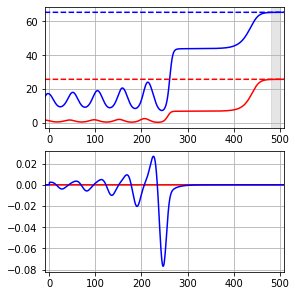

In [13]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-10
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0]
        target_[:,1,:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.05 0.0 313.22985858994934
interpolate adjoint :  True True True
initial cost =  94.34583931638542
RUN  0 , total integrated cost =  94.34583931638542
Gradient descend method:  None
RUN  1 , total integrated cost =  94.34565805233515
RUN  2 , total integrated cost =  94.34565798686837
RUN  3 , total integrated cost =  94.34565798356833
RUN  4 , total integrated cost =  94.34565798251867
RUN  5 , total integrated cost =  94.34565798180579
RUN  6 , total integrated cost =  94.34565798180579
Control only changes marginally.
RUN  6 , total integrated cost =  94.34565798180579
Improved over  6  iterations in  1.3161432560009416  seconds by  0.0001922019889235571  percent.
cost splitting :  0.007227527543682226 [8.67408427e-12 3.01201479e-01]
set cost params:  0.05 0.0 16.331648156952127
interpolate adjoint :  True True True
initial cost =  4.919477952170288
RUN  0 , total integrated cost =  4.919477952170288
Gradient descend method:  None
RUN  1 , total integrated cost = 

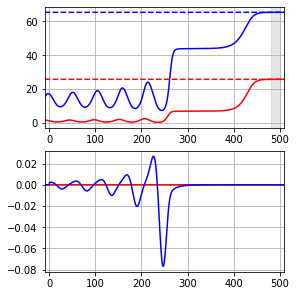

In [14]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-12
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0]
        target_[:,1,:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)